In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import util
import scanpy as sc
import tifffile
from skimage.filters import threshold_otsu
import os

# import plotly.graph_objects as go
# import plotly.express as px

import matplotlib.pyplot as plt
from matplotlib import rc_context

from joblib import Parallel, delayed
from tqdm import tqdm

import neighborhoodAnalysis as nha

c:\Users\zfang38\Anaconda3\envs\skim\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
scale = 249.6/2304
z_scale = 0.3/1

# Load data

In [145]:
cell_df = pd.read_csv(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_analysis\spagnn\cell_df\bm_007_13.csv',index_col=0)
cell_by_gene = cell_df.groupby('gene')

In [69]:
gene_color_dict = {'ACAN':'#ffffff', 'ACTb':'#b60000', 'ALPL':'#008c00', 'CCL11':'#c34fff',
                   'CCL19':'#01a5ca', 'CD105':'#ec9d00', 'CD11B':'#76ff00', 'CD19':'#ff7598',
                   'CD34':'#940073', 'CD45':'#00f3cc', 'CD79B':'#4853ff', 'CD90':'#a6a19a',
                   'COL1A1':'#edb7ff', 'COL2A1':'#8a6800', 'COL5A2':'#6100a3', 'COMP':'#fff585',
                   'CXCR4':'#007b69', 'EEF2':'#92b853', 'GAPDH':'#abd4ff', 'HLA-DRA':'#7e79a3',
                   'IBSP':'#ff5401', 'IL6':'#0a577d', 'IL8':'#a8615c', 'MALAT1':'#e700b9',
                   'MKI67':'#ffc3a6', 'NANOG':'#00b485', 'PDL1':'#7e9eff', 'PTH1R':'#b8d8b7',
                   'RUNX1':'#c082b7', 'SOX9':'#6f895b', 'SPP1':'#8a48a2'}

In [70]:
gene_groups = [['GAPDH','CD105','CD11B','CD19','CD34',],
               ['ACTb','CD79B','CD45','CD90','HLA-DRA'],
               ['MALAT1','PDL1','COL5A2','COL2A1','RUNX1','PTH1R'],
               ['COL1A1','ACAN','ALPL','COMP','IBSP'],
               ['EEF2','MKI67','SOX9','SPP1','NANOG'],
               ['IL6','IL8','CXCR4','CCL19','CCL11']]

In [71]:
colors = ['#b60000','#ec9d00','#008c00','#c34fff','#01a5ca','#abd4ff','#ffffff']

In [12]:
mask = tifffile.imread(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_segmentation\cellpose\combined_rna\bm_rgb_combined\masks\007_mask.tif')
mask = (mask==13).astype('int')

dapi_mip = tifffile.imread(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_segmentation\cellpose\combined_rna\bm_rgb_combined\imgs\007_image.tif')
dapi_mip = dapi_mip[2,:,:]

masked_dapi = mask * dapi_mip
thre = threshold_otsu(masked_dapi)
dapi_mask = masked_dapi > thre

dapi_coor = np.where(dapi_mask)
dapi_row = dapi_coor[0].astype('float') * scale
dapi_col = dapi_coor[1].astype('float') * scale

dapi_z = 12 * z_scale

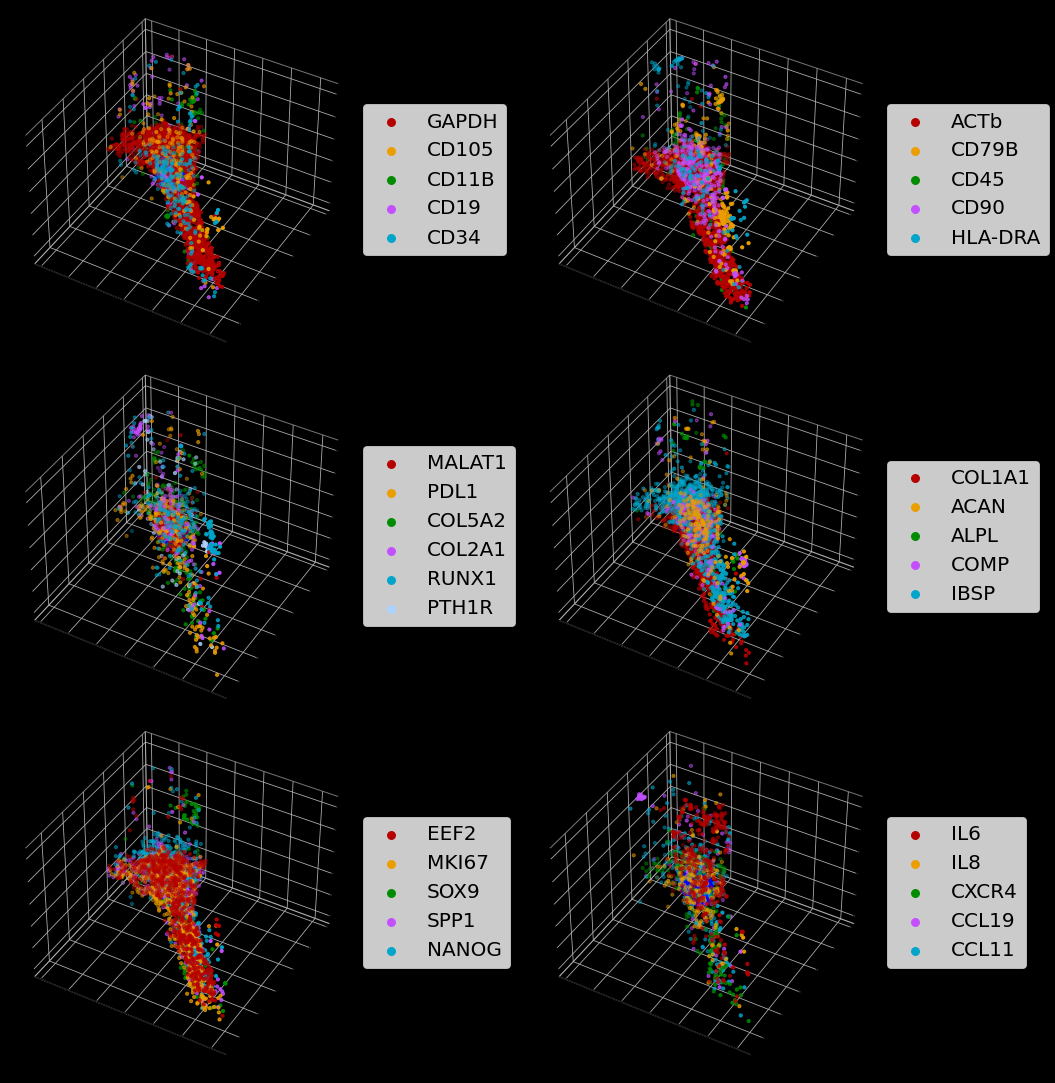

In [87]:
# subset of gnes
fig = plt.figure(figsize=(16,15))
for i,item in enumerate(gene_groups):
    ax = fig.add_subplot(3,2,i+1,projection='3d')
    fig.set_facecolor('black')
    ax.set_facecolor('black')
    ax.w_xaxis.pane.fill = False
    ax.w_yaxis.pane.fill = False
    ax.w_zaxis.pane.fill = False
    ax.invert_zaxis()
    
    ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
    
    for j,item in enumerate(gene_groups[i]):
        sub_group = cell_by_gene.get_group(item)
        ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,
                   color=colors[j],s=10,label=item)
        
    ax.view_init(-140, 60)
    ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=1,fontsize=20,markerscale=2.5)

plt.tight_layout()

plt.savefig(r'.\figures\bm_007_13_5sets.png',dpi=300)

In [73]:
gel_df = pd.read_csv(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_analysis\detected_dots\hydrogel_df.csv',index_col=0)

In [74]:
gel_df

row   col   z     cellID   gene
0         800   140  16  bm_001_03   CD19
1         800   141  16  bm_001_03   CD19
2         686   538  17  bm_001_03   CD19
3         743   391   5  bm_001_03   CD19
4         806   286  10  bm_001_03   CD19
...       ...   ...  ..        ...    ...
9428182  1357  1563  13  uc_047_03  CCL19
9428183   333  1475  12  uc_047_01  CCL19
9428184  1017  1076  11  uc_047_03  CCL19
9428185   989  1336   6  uc_047_03  CCL19
9428186  1069  1168   8  uc_047_03  CCL19

[9428187 rows x 5 columns]

# bm 007 fov

In [34]:
df_007 = gel_df[gel_df['cellID'].str.contains('bm_007')]

In [46]:
df_007['cellID'].unique()

array(['bm_007_03', 'bm_007_13', 'bm_007_15', 'bm_007_17', 'bm_007_10',
       'bm_007_08', 'bm_007_09', 'bm_007_11', 'bm_007_16', 'bm_007_04',
       'bm_007_02', 'bm_007_14', 'bm_007_05', 'bm_007_07', 'bm_007_06',
       'bm_007_12', 'bm_007_01'], dtype=object)

In [36]:
mask = tifffile.imread(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_segmentation\cellpose\combined_rna\bm_rgb_combined\masks\007_mask.tif')
mask = (mask>0).astype('int')

In [37]:
dapi_mip = tifffile.imread(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_segmentation\cellpose\combined_rna\bm_rgb_combined\imgs\007_image.tif')
dapi_mip = dapi_mip[2,:,:]

In [38]:
masked_dapi = mask * dapi_mip
thre = threshold_otsu(masked_dapi)
dapi_mask = masked_dapi > thre

In [39]:
dapi_coor = np.where(dapi_mask)
dapi_row = dapi_coor[0].astype('float') * scale
dapi_col = dapi_coor[1].astype('float') * scale

In [40]:
dapi_z = 12 * z_scale

In [41]:
fov_by_gene = df_007.groupby('gene')

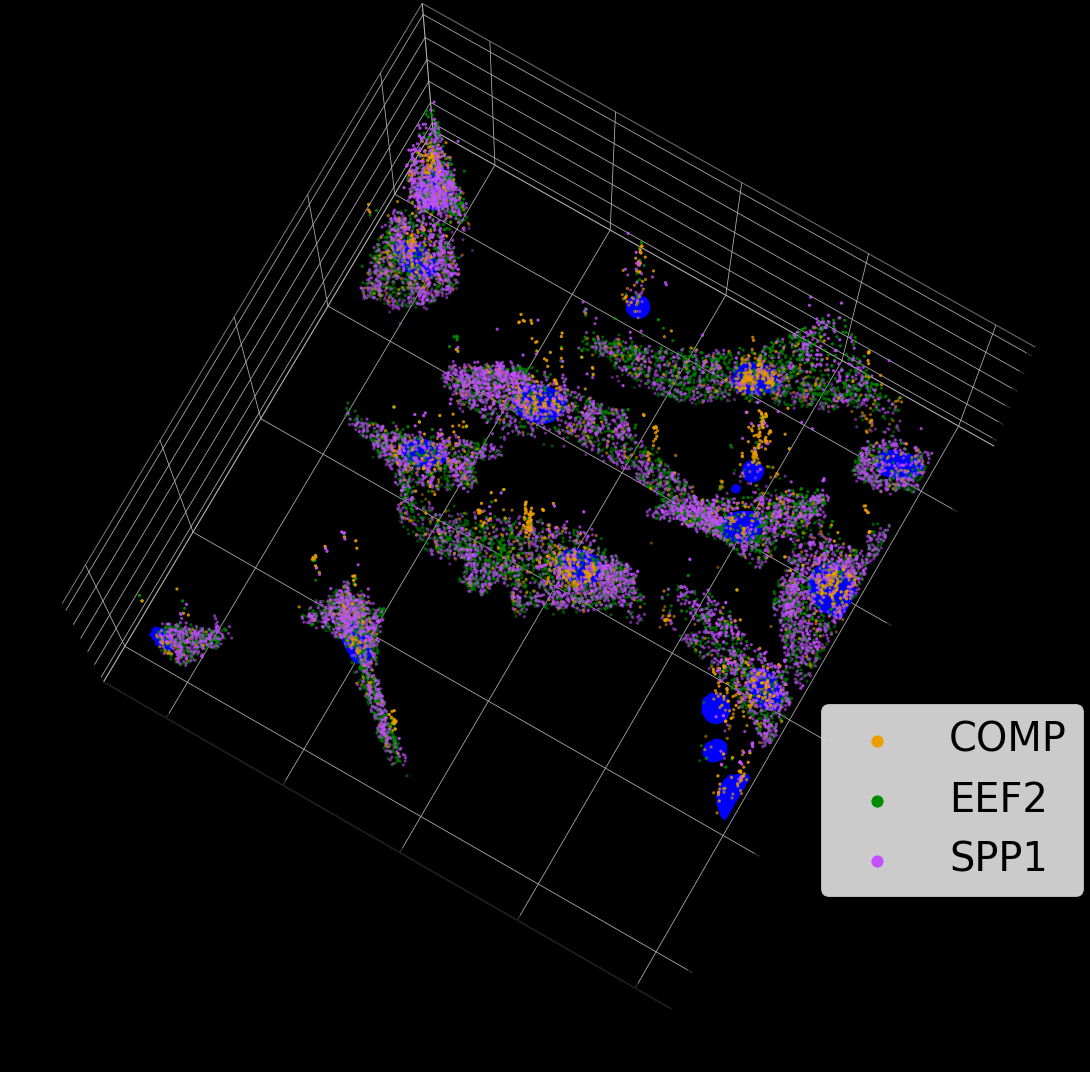

In [83]:
# subset of gnes
fig = plt.figure(figsize=(16,15))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=0.5)

sub_group = fov_by_gene.get_group('COMP')
ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,s=5,color=colors[1],label='COMP')

sub_group = fov_by_gene.get_group('EEF2')
ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,s=5,color=colors[2],label='EEF2')

sub_group = fov_by_gene.get_group('SPP1')
ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,s=5,color=colors[3],label='SPP1')

# sub_group = fov_by_gene.get_group('EEF2')
# ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,color=colors[3],label='EEF2')
        
ax.view_init(-100, 60)

ax.legend(loc='center left',bbox_to_anchor=(0.75,0.25),ncol=1,fontsize=40,markerscale=5)

plt.tight_layout()

plt.savefig(r'.\figures\bm_007.png',dpi=300)

# uc 018-1

In [144]:
cell_df = pd.read_csv(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_analysis\spagnn\cell_df\uc_018_01.csv',index_col=0)
cell_by_gene = cell_df.groupby('gene')

In [105]:
mask = tifffile.imread(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_segmentation\cellpose\combined_rna\uc_rgb_combined\masks\018_mask.tif')
mask = (mask==1).astype('int')

dapi_mip = tifffile.imread(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_segmentation\cellpose\combined_rna\uc_rgb_combined\imgs\018_image.tif')
dapi_mip = dapi_mip[2,:,:]

masked_dapi = mask * dapi_mip
thre = threshold_otsu(masked_dapi)
dapi_mask = masked_dapi > thre

dapi_coor = np.where(dapi_mask)
dapi_row = dapi_coor[0].astype('float') * scale
dapi_col = dapi_coor[1].astype('float') * scale

dapi_z = 12 * z_scale

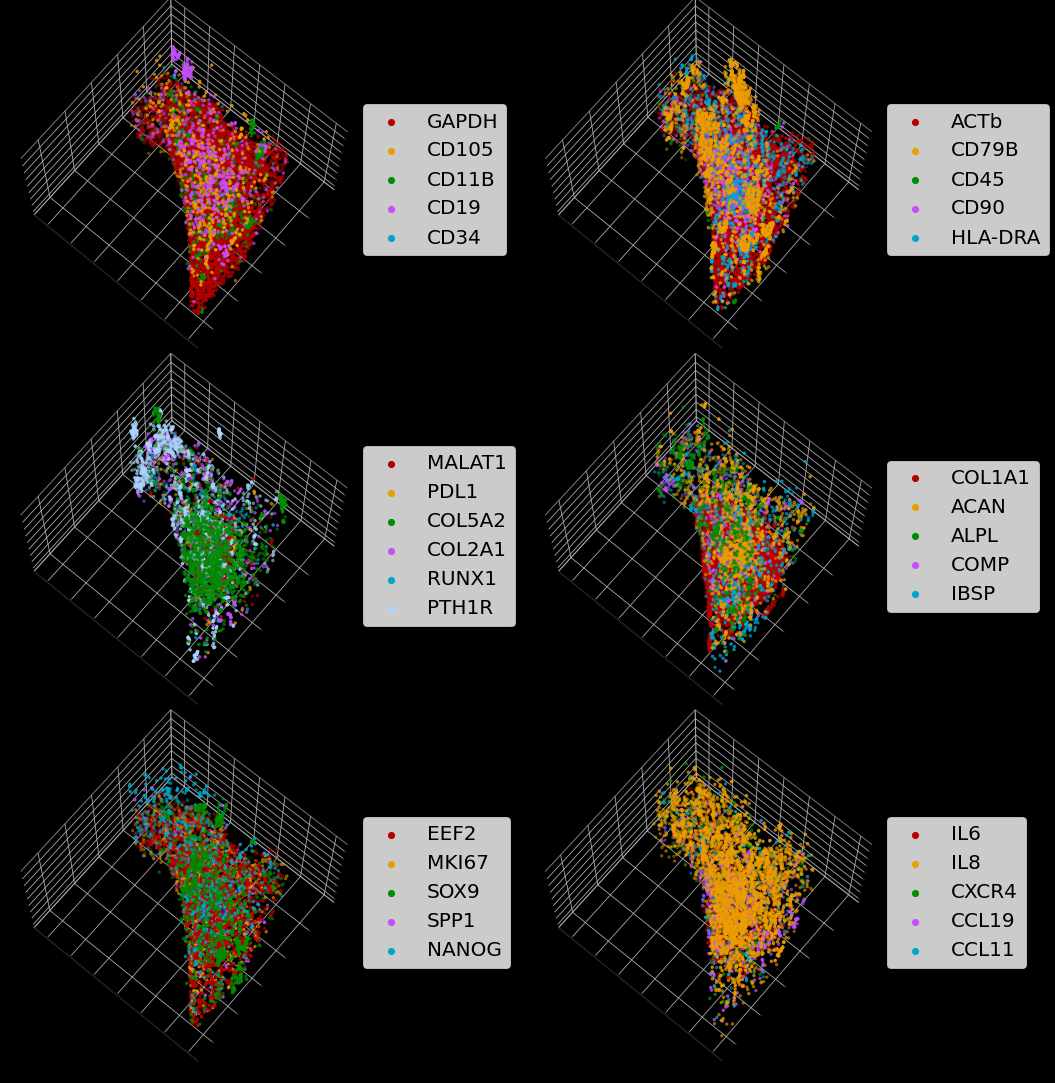

In [107]:
# subset of gnes
fig = plt.figure(figsize=(16,15))
for i,item in enumerate(gene_groups):
    ax = fig.add_subplot(3,2,i+1,projection='3d')
    fig.set_facecolor('black')
    ax.set_facecolor('black')
    ax.w_xaxis.pane.fill = False
    ax.w_yaxis.pane.fill = False
    ax.w_zaxis.pane.fill = False
    ax.invert_zaxis()
    
    ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
    
    for j,item in enumerate(gene_groups[i]):
        sub_group = cell_by_gene.get_group(item)
        ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,
                   color=colors[j],s=6,label=item)
        
    ax.view_init(-110, 50)
    ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=1,fontsize=20,markerscale=2.5)

plt.tight_layout()

plt.savefig(r'.\figures\uc_018_01_5sets.png',dpi=300)

In [146]:
cell_by_patch = cell_df.groupby('patch')

In [149]:
cell_adata = sc.read_h5ad(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_analysis\spagnn\cell_adata\uc_018_01.h5ad')
patch_colors = (cell_adata.uns['leiden_colors'].astype(str)).tolist()

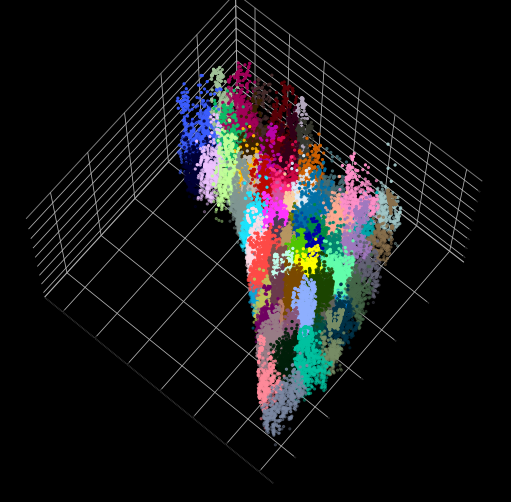

In [157]:
# subset of gnes
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

for p in cell_by_patch.groups.keys():
    patch_rna = cell_by_patch.get_group(p)
    ax.scatter(patch_rna['row']*scale,patch_rna['col']*scale,patch_rna['z']*z_scale,
               color=patch_colors[p],s=5,label=item)
    
        
    ax.view_init(-110, 50)
    # ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=1,fontsize=20,markerscale=2.5)

plt.tight_layout()

plt.savefig(r'.\figures\uc_018_01_patches.png',dpi=300)

In [195]:
cell_df[]

row   col   z     cellID   gene  patch
2850922  979   724   6  uc_018_01   CD19     32
2850923  995   946  16  uc_018_01   CD19      6
2850924  996   944  16  uc_018_01   CD19      6
2850925  994   944  16  uc_018_01   CD19      6
2850926  994   943  16  uc_018_01   CD19      6
...      ...   ...  ..        ...    ...    ...
9388816  211   423   2  uc_018_01  CCL19     52
9388818  271   577   8  uc_018_01  CCL19      0
9388831  360   658  14  uc_018_01  CCL19      9
9388842  301  1044   9  uc_018_01  CCL19     68
9388843  638   672  14  uc_018_01  CCL19      1

[44228 rows x 6 columns]

# uc 018 fov

In [108]:
df_018 = gel_df[gel_df['cellID'].str.contains('uc_018')]

In [109]:
mask = tifffile.imread(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_segmentation\cellpose\combined_rna\uc_rgb_combined\masks\018_mask.tif')
mask = (mask>0).astype('int')

In [110]:
dapi_mip = tifffile.imread(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_segmentation\cellpose\combined_rna\uc_rgb_combined\imgs\018_image.tif')
dapi_mip = dapi_mip[2,:,:]

In [111]:
masked_dapi = mask * dapi_mip
thre = threshold_otsu(masked_dapi)
dapi_mask = masked_dapi > thre

In [112]:
dapi_coor = np.where(dapi_mask)
dapi_row = dapi_coor[0].astype('float') * scale
dapi_col = dapi_coor[1].astype('float') * scale

In [113]:
dapi_z = 12 * z_scale

In [114]:
fov_by_gene = df_018.groupby('gene')

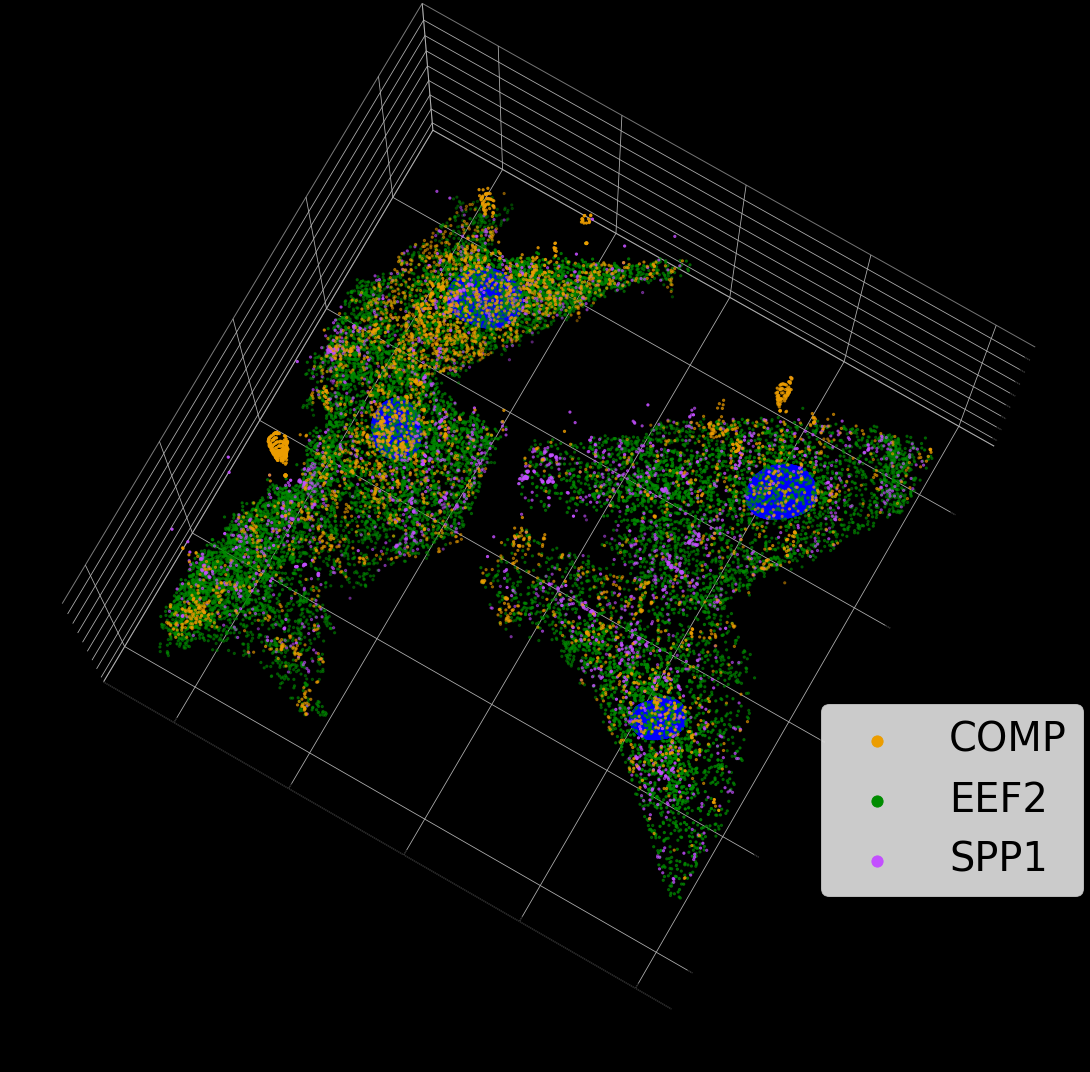

In [115]:
# subset of gnes
fig = plt.figure(figsize=(16,15))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=0.5)

sub_group = fov_by_gene.get_group('COMP')
ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,s=5,color=colors[1],label='COMP')

sub_group = fov_by_gene.get_group('EEF2')
ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,s=5,color=colors[2],label='EEF2')

sub_group = fov_by_gene.get_group('SPP1')
ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,s=5,color=colors[3],label='SPP1')

# sub_group = fov_by_gene.get_group('EEF2')
# ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,color=colors[3],label='EEF2')
        
ax.view_init(-100, 60)

ax.legend(loc='center left',bbox_to_anchor=(0.75,0.25),ncol=1,fontsize=40,markerscale=5)

plt.tight_layout()

plt.savefig(r'.\figures\uc_018.png',dpi=300)

# Embedding feature heatmap

In [87]:
import seaborn as sns

In [88]:
embedding = pd.read_csv(r'.\results\gae_embedded_features.csv',index_col=0)

In [93]:
# bm_007_13_16 bm_007_13_19 bm_007_13_26 bm_007_13_33

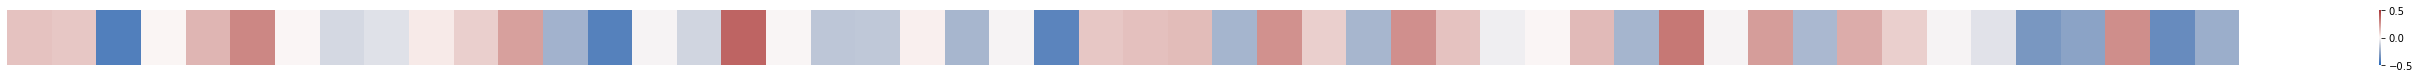

In [110]:
plt.figure(figsize=(50, 1))
sns.heatmap(embedding.loc['bm_007_13_16'].to_frame().T,cmap='vlag',vmin=-0.5,vmax=0.5,xticklabels=False, yticklabels=False)
plt.savefig(r'.\figures\embedding_features_bm_007_13_16.png')

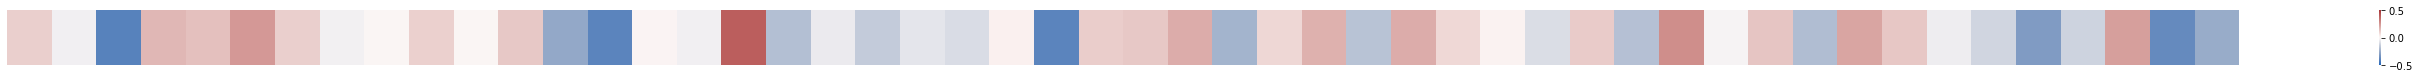

In [111]:
plt.figure(figsize=(50, 1))
sns.heatmap(embedding.loc['bm_007_13_19'].to_frame().T,cmap='vlag',vmin=-0.5,vmax=0.5,xticklabels=False, yticklabels=False)
plt.savefig(r'.\figures\embedding_features_bm_007_13_19.png')

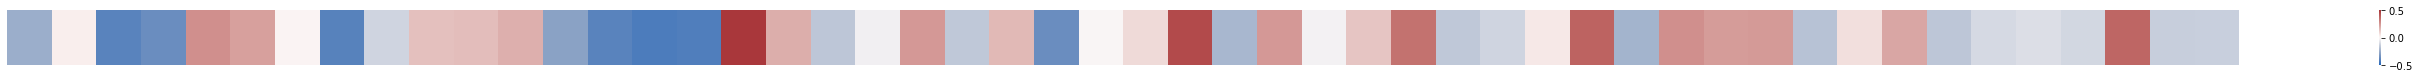

In [112]:
plt.figure(figsize=(50, 1))
sns.heatmap(embedding.loc['bm_007_13_26'].to_frame().T,cmap='vlag',vmin=-0.5,vmax=0.5,xticklabels=False, yticklabels=False)
plt.savefig(r'.\figures\embedding_features_bm_007_13_26.png')

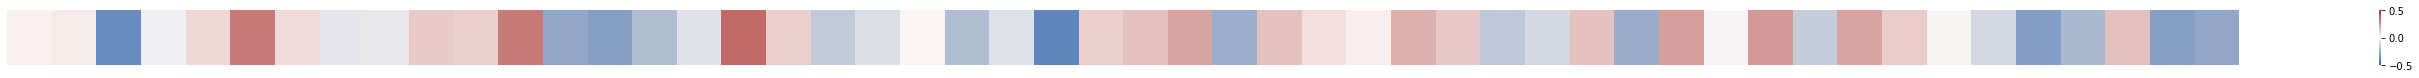

In [113]:
plt.figure(figsize=(50, 1))
sns.heatmap(embedding.loc['bm_007_13_33'].to_frame().T,cmap='vlag',vmin=-0.5,vmax=0.5,xticklabels=False, yticklabels=False)
plt.savefig(r'.\figures\embedding_features_bm_007_13_33.png')

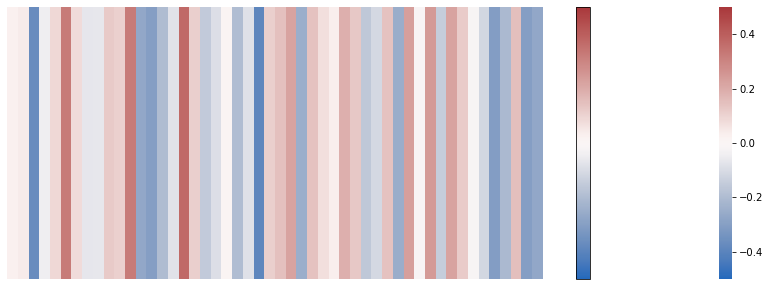

In [128]:
plt.figure(figsize=(15, 5))
heatmap = sns.heatmap(embedding.loc['bm_007_13_33'].to_frame().T,cmap='vlag',vmin=-0.5,vmax=0.5,xticklabels=False, yticklabels=False)

with rc_context({'font.size':25,'ytick.color': 'white'}):  # Change 'ytick.color' to 'xtick.color' if needed
    plt.colorbar(heatmap.get_children()[0], ax=heatmap)

plt.savefig(r'.\figures\color map.png')

# plot embedding features by dot colors

In [86]:
proxi_df = pd.read_csv(r'.\results\proxi_df.csv',index_col=0)
proxi_by_cell = proxi_df.groupby('cellID')
bm_007_13 = proxi_by_cell.get_group('bm_007_13')

In [8]:
embedding

1         2         3         4         5         6  \
bm_001_01_0   0.133491  0.049819 -0.216774  0.015934 -0.083404  0.150778   
bm_001_01_1  -0.175297  0.057750 -0.045509  0.187772 -0.073505 -0.048532   
bm_001_01_2  -0.094484 -0.035670 -0.064323  0.000226 -0.140458  0.104816   
bm_001_01_3  -0.211751 -0.005190 -0.031677  0.066307 -0.111203 -0.012707   
bm_001_01_4   0.102304  0.059926 -0.180779  0.010392 -0.101629  0.113652   
...                ...       ...       ...       ...       ...       ...   
uc_047_05_46 -0.259811 -0.167347  0.103615 -0.202420 -0.195573 -0.049169   
uc_047_05_47  0.154123 -0.178316 -0.122551 -0.015987 -0.124164 -0.068107   
uc_047_05_48  0.124094  0.152764  0.031000 -0.089696 -0.358432 -0.169728   
uc_047_05_49  0.066837 -0.056448  0.023526  0.046105 -0.232864  0.119689   
uc_047_05_50  0.157610 -0.033047  0.024541  0.045096 -0.022709 -0.081055   

                     7         8         9        10  ...        96        97  \
bm_001_01_0   0.288539  0.058014 -0.011838  0.066314  ...  0.251209  0.047553   
bm_001_01_1   0.123248 -0.066662  0.321819 -0.226296  ...  0.356954 -0.061827   
bm_001_01_2   0.068818  0.140446 -0.051742  0.002350  ...  0.118130 -0.097594   
bm_001_01_3   0.027698  0.088333  0.122412 -0.158073  ...  0.114330 -0.030061   
bm_001_01_4   0.209493  0.034273 -0.047150  0.045001  ...  0.225894 -0.016591   
...                ...       ...       ...       ...  ...       ...       ...   
uc_047_05_46 -0.301129  0.228135  0.059822 -0.144613  ... -0.035543 -0.266260   
uc_047_05_47 -0.020095 -0.171674  0.093814 -0.010315  ...  0.049071  0.154365   
uc_047_05_48  0.326231  0.135734 -0.333806 -0.057691  ... -0.095819 -0.056547   
uc_047_05_49  0.166379  0.157568  0.230702  0.079585  ...  0.008037 -0.108842   
uc_047_05_50 -0.132896 -0.100360  0.090654  0.017530  ... -0.157499 -0.053942   

                    98        99       100          row         col  \
bm_001_01_0   0.160021  0.113359  0.050917   167.983607  580.934426   
bm_001_01_1  -0.047485  0.196687 -0.118396   219.658333  492.091667   
bm_001_01_2  -0.044369  0.038023  0.057828   137.956522  548.521739   
bm_001_01_3  -0.007405  0.253388 -0.006455   176.945455  526.390909   
bm_001_01_4   0.116273  0.069692  0.089192   148.495413  575.954128   
...                ...       ...       ...          ...         ...   
uc_047_05_46 -0.111388  0.056950 -0.147607  1724.725000  472.520000   
uc_047_05_47 -0.063477 -0.249080 -0.277742  1602.498728  531.333333   
uc_047_05_48 -0.126515  0.011176  0.158422  1488.423280  691.671958   
uc_047_05_49  0.060741 -0.070457 -0.087670  1857.138365  673.716981   
uc_047_05_50 -0.091381  0.115994 -0.120782  1660.135135  419.045045   

                      z  cluster     cellID  
bm_001_01_0   13.459016        0  bm_001_01  
bm_001_01_1   16.541667        5  bm_001_01  
bm_001_01_2   13.391304        1  bm_001_01  
bm_001_01_3   10.318182        9  bm_001_01  
bm_001_01_4   14.669725        0  bm_001_01  
...                 ...      ...        ...  
uc_047_05_46  12.935000        2  uc_047_05  
uc_047_05_47   9.824427        8  uc_047_05  
uc_047_05_48  10.142857        6  uc_047_05  
uc_047_05_49  10.062893        0  uc_047_05  
uc_047_05_50   6.932432        2  uc_047_05  

[25441 rows x 105 columns]

## bm 007-13

In [9]:
sub_embedding = embedding[embedding.index.str.contains('bm_007_13')]

In [10]:
connected_pairs = nha.find_connected_pairs(bm_007_13,5,'row','col','z')

In [13]:
mask = tifffile.imread(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_segmentation\cellpose\combined_rna\bm_rgb_combined\masks\007_mask.tif')
mask = (mask==13).astype('int')

dapi_mip = tifffile.imread(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_segmentation\cellpose\combined_rna\bm_rgb_combined\imgs\007_image.tif')
dapi_mip = dapi_mip[2,:,:]

masked_dapi = mask * dapi_mip
thre = threshold_otsu(masked_dapi)
dapi_mask = masked_dapi > thre

dapi_coor = np.where(dapi_mask)
dapi_row = dapi_coor[0].astype('float') * scale
dapi_col = dapi_coor[1].astype('float') * scale

dapi_z = 12 * z_scale

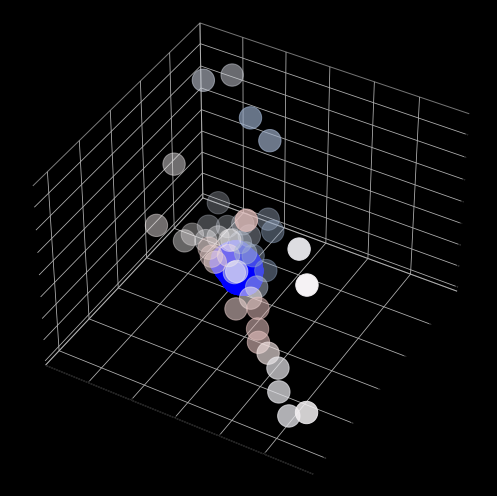

In [14]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(bm_007_13['row']*scale, bm_007_13['col']*scale,bm_007_13['z']*z_scale,'.',
           c=sub_embedding['24'], s=500, cmap='vlag', vmin=-0.5, vmax=0.5)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

# for item in connected_pairs:
#     ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
#             color='y',linewidth=3)

ax.view_init(-140, 60)
plt.tight_layout()
plt.savefig(r'.\figures\bm_007_13_embedding_24.png')

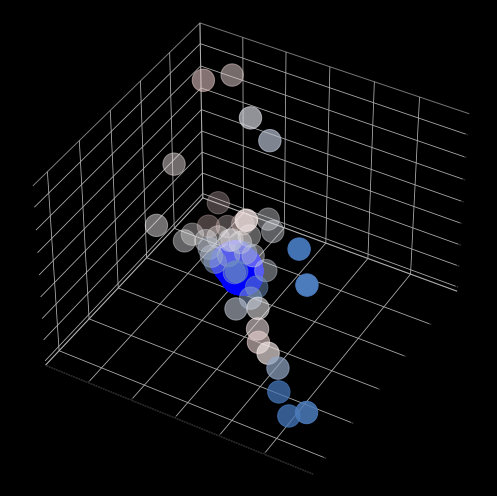

In [15]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(bm_007_13['row']*scale, bm_007_13['col']*scale,bm_007_13['z']*z_scale,'.',
           c=sub_embedding['46'], s=500, cmap='vlag', vmin=-0.5, vmax=0.5)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

# for item in connected_pairs:
#     ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
#             color='y',linewidth=3)

ax.view_init(-140, 60)
plt.tight_layout()
plt.savefig(r'.\figures\bm_007_13_embedding_46.png')

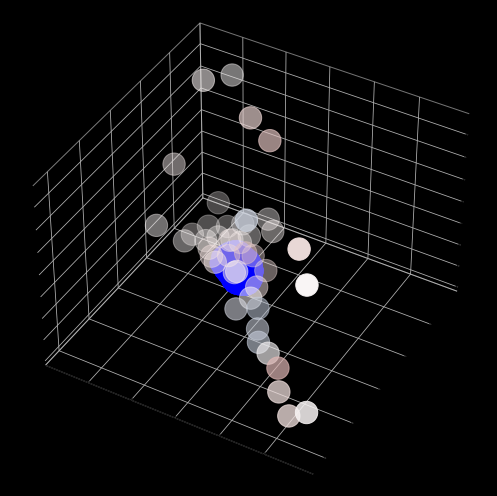

In [16]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(bm_007_13['row']*scale, bm_007_13['col']*scale,bm_007_13['z']*z_scale,'.',
           c=sub_embedding['59'], s=500, cmap='vlag', vmin=-0.5, vmax=0.5)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

# for item in connected_pairs:
#     ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
#             color='y',linewidth=3)

ax.view_init(-140, 60)
plt.tight_layout()
plt.savefig(r'.\figures\bm_007_13_embedding_59.png')

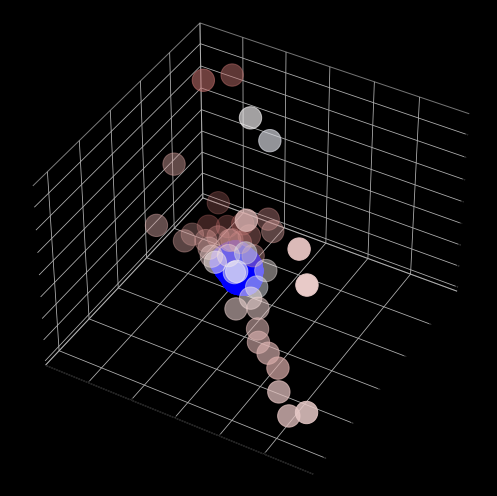

In [17]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(bm_007_13['row']*scale, bm_007_13['col']*scale,bm_007_13['z']*z_scale,'.',
           c=sub_embedding['75'], s=500, cmap='vlag', vmin=-0.5, vmax=0.5)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

# for item in connected_pairs:
#     ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
#             color='y',linewidth=3)

ax.view_init(-140, 60)
plt.tight_layout()
plt.savefig(r'.\figures\bm_007_13_embedding_75.png')

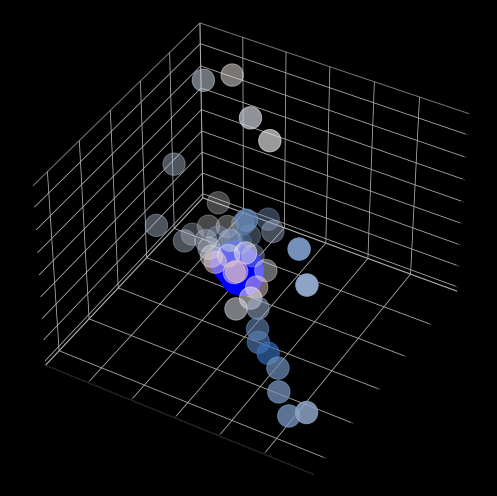

In [151]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(bm_007_13['row']*scale, bm_007_13['col']*scale,bm_007_13['z']*z_scale,'.',
           c=sub_embedding['1'], s=500, cmap='vlag', vmin=-0.5, vmax=0.5)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

# for item in connected_pairs:
#     ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
#             color='y',linewidth=3)

ax.view_init(-140, 60)
plt.tight_layout()
plt.savefig(r'.\figures\bm_007_13_embedding_1.png')

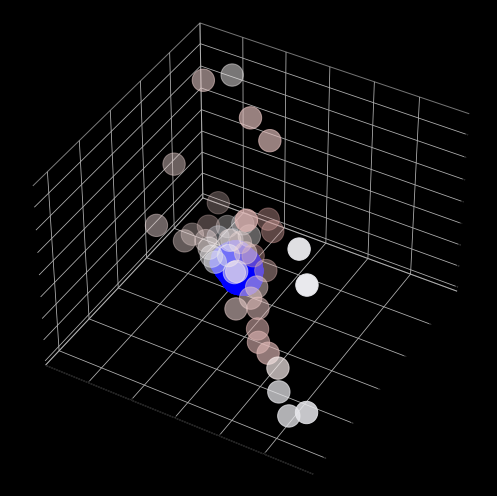

In [152]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(bm_007_13['row']*scale, bm_007_13['col']*scale,bm_007_13['z']*z_scale,'.',
           c=sub_embedding['10'], s=500, cmap='vlag', vmin=-0.5, vmax=0.5)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

# for item in connected_pairs:
#     ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
#             color='y',linewidth=3)

ax.view_init(-140, 60)
plt.tight_layout()
plt.savefig(r'.\figures\bm_007_13_embedding_10.png')

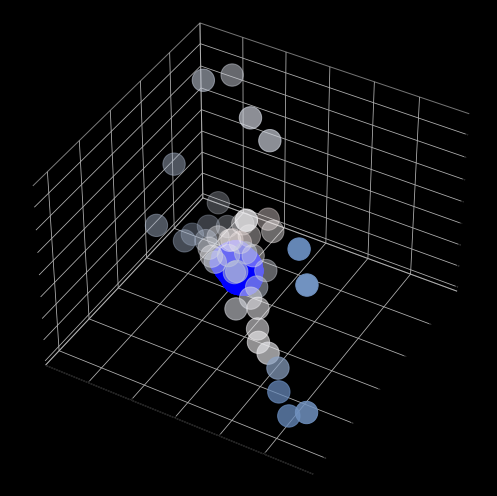

In [153]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(bm_007_13['row']*scale, bm_007_13['col']*scale,bm_007_13['z']*z_scale,'.',
           c=sub_embedding['20'], s=500, cmap='vlag', vmin=-0.5, vmax=0.5)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

# for item in connected_pairs:
#     ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
#             color='y',linewidth=3)

ax.view_init(-140, 60)
plt.tight_layout()
plt.savefig(r'.\figures\bm_007_13_embedding_20.png')

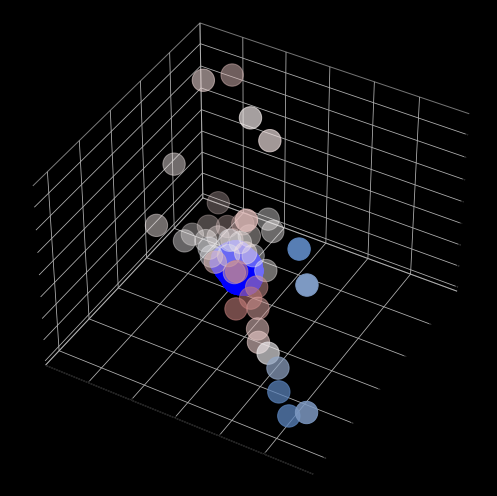

In [156]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(bm_007_13['row']*scale, bm_007_13['col']*scale,bm_007_13['z']*z_scale,'.',
           c=sub_embedding['6'], s=500, cmap='vlag', vmin=-0.5, vmax=0.5)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

# for item in connected_pairs:
#     ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
#             color='y',linewidth=3)

ax.view_init(-140, 60)
plt.tight_layout()
plt.savefig(r'.\figures\bm_007_13_embedding_6.png')

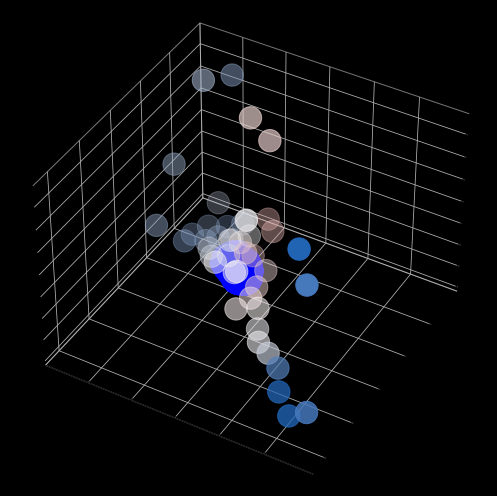

In [157]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(bm_007_13['row']*scale, bm_007_13['col']*scale,bm_007_13['z']*z_scale,'.',
           c=sub_embedding['7'], s=500, cmap='vlag', vmin=-0.5, vmax=0.5)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

# for item in connected_pairs:
#     ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
#             color='y',linewidth=3)

ax.view_init(-140, 60)
plt.tight_layout()
plt.savefig(r'.\figures\bm_007_13_embedding_7.png')

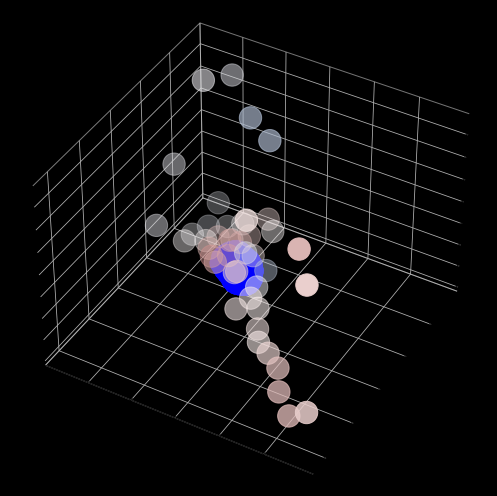

In [158]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(bm_007_13['row']*scale, bm_007_13['col']*scale,bm_007_13['z']*z_scale,'.',
           c=sub_embedding['2'], s=500, cmap='vlag', vmin=-0.5, vmax=0.5)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

# for item in connected_pairs:
#     ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
#             color='y',linewidth=3)

ax.view_init(-140, 60)
plt.tight_layout()
plt.savefig(r'.\figures\bm_007_13_embedding_2.png')

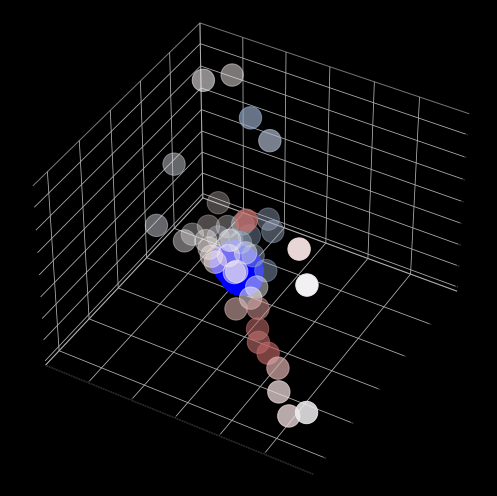

In [159]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(bm_007_13['row']*scale, bm_007_13['col']*scale,bm_007_13['z']*z_scale,'.',
           c=sub_embedding['21'], s=500, cmap='vlag', vmin=-0.5, vmax=0.5)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

# for item in connected_pairs:
#     ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
#             color='y',linewidth=3)

ax.view_init(-140, 60)
plt.tight_layout()
plt.savefig(r'.\figures\bm_007_13_embedding_21.png')

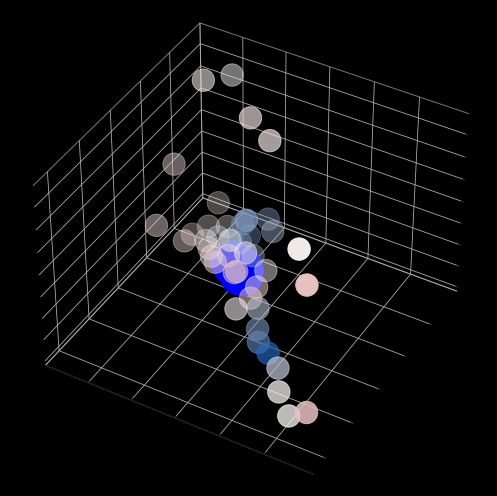

In [160]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(bm_007_13['row']*scale, bm_007_13['col']*scale,bm_007_13['z']*z_scale,'.',
           c=sub_embedding['33'], s=500, cmap='vlag', vmin=-0.5, vmax=0.5)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

# for item in connected_pairs:
#     ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
#             color='y',linewidth=3)

ax.view_init(-140, 60)
plt.tight_layout()
plt.savefig(r'.\figures\bm_007_13_embedding_33.png')

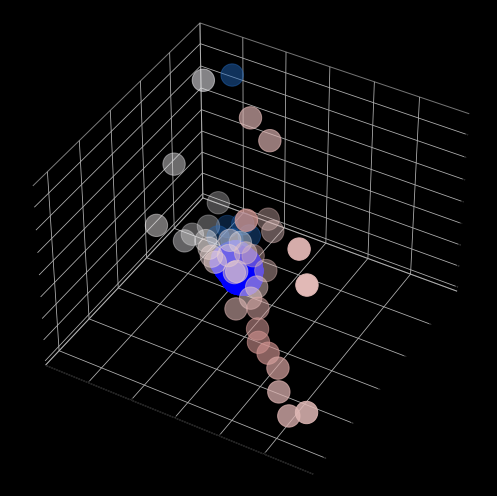

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(bm_007_13['row']*scale, bm_007_13['col']*scale,bm_007_13['z']*z_scale,'.',
           c=sub_embedding['43'], s=500, cmap='vlag', vmin=-0.5, vmax=0.5)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

# for item in connected_pairs:
#     ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
#             color='y',linewidth=3)

ax.view_init(-140, 60)
plt.tight_layout()
plt.savefig(r'.\figures\bm_007_13_embedding_43.png')

<AxesSubplot:>

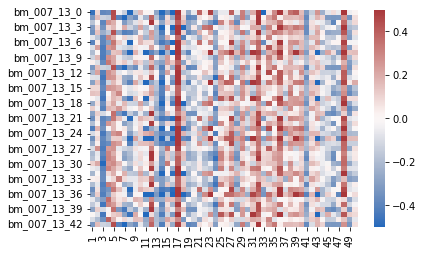

In [155]:
sns.heatmap(sub_embedding,cmap='vlag', vmin=-0.5, vmax=0.5)

## UC plots

In [116]:
sub_embedding = embedding[embedding.index.str.contains('uc_018_01')]

In [117]:
connected_pairs = nha.find_connected_pairs(sub_embedding,5,'row','col','z')

In [138]:
mask = tifffile.imread(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_segmentation\cellpose\combined_rna\uc_rgb_combined\masks\018_mask.tif')
mask = (mask==1).astype('int')

dapi_mip = tifffile.imread(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_segmentation\cellpose\combined_rna\uc_rgb_combined\imgs\018_image.tif')
dapi_mip = dapi_mip[2,:,:]

masked_dapi = mask * dapi_mip
thre = threshold_otsu(masked_dapi)
dapi_mask = masked_dapi > thre

dapi_coor = np.where(dapi_mask)
dapi_row = dapi_coor[0].astype('float') * scale
dapi_col = dapi_coor[1].astype('float') * scale

dapi_z = 12 * z_scale

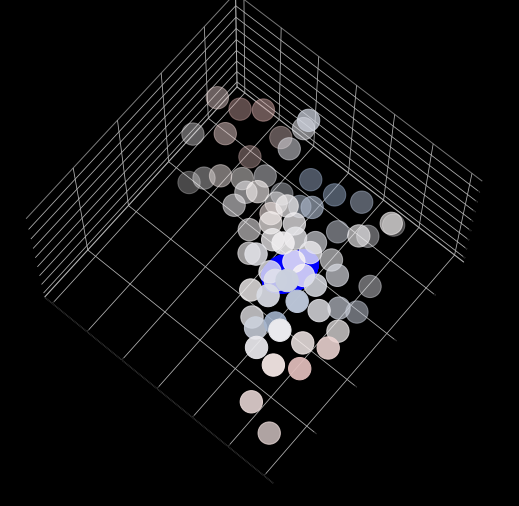

In [120]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(sub_embedding['row']*scale, sub_embedding['col']*scale,sub_embedding['z']*z_scale,'.',
           c=sub_embedding['24'], s=500, cmap='vlag', vmin=-0.5, vmax=0.5)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

# for item in connected_pairs:
#     ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
#             color='y',linewidth=3)

ax.view_init(-110, 50)
plt.tight_layout()
plt.savefig(r'.\figures\uc_018_01_embedding_24.png')

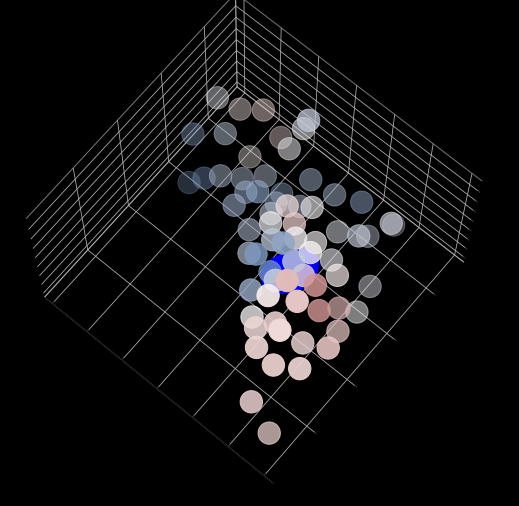

In [121]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(sub_embedding['row']*scale, sub_embedding['col']*scale,sub_embedding['z']*z_scale,'.',
           c=sub_embedding['46'], s=500, cmap='vlag', vmin=-0.5, vmax=0.5)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

# for item in connected_pairs:
#     ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
#             color='y',linewidth=3)

ax.view_init(-110, 50)
plt.tight_layout()
plt.savefig(r'.\figures\uc_018_01_embedding_46.png')

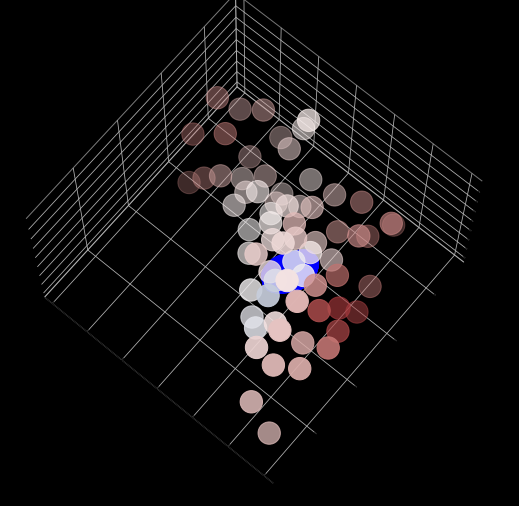

In [125]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(sub_embedding['row']*scale, sub_embedding['col']*scale,sub_embedding['z']*z_scale,'.',
           c=sub_embedding['59'], s=500, cmap='vlag', vmin=-0.5, vmax=0.5)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

# for item in connected_pairs:
#     ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
#             color='y',linewidth=3)

ax.view_init(-110, 50)
plt.tight_layout()
plt.savefig(r'.\figures\uc_018_01_embedding_59.png')

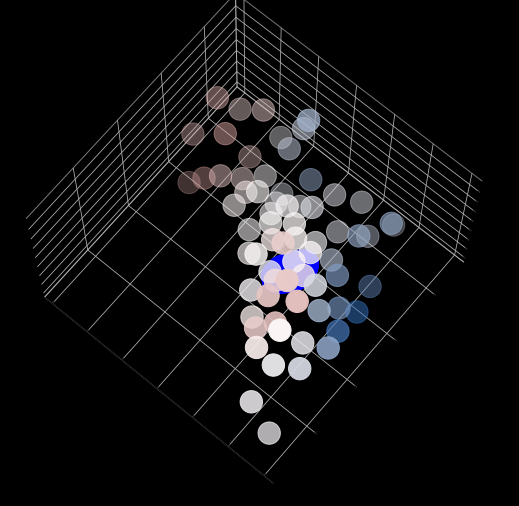

In [124]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(sub_embedding['row']*scale, sub_embedding['col']*scale,sub_embedding['z']*z_scale,'.',
           c=sub_embedding['75'], s=500, cmap='vlag', vmin=-0.5, vmax=0.5)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

# for item in connected_pairs:
#     ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
#             color='y',linewidth=3)

ax.view_init(-110, 50)
plt.tight_layout()
plt.savefig(r'.\figures\uc_018_01_embedding_75.png')

In [133]:
edge_row = []
edge_col = []
edge_z = []
for item in connected_pairs:
    edge_row.append(sub_embedding.loc[item[0]]['row'].astype('float'))
    edge_row.append(sub_embedding.loc[item[1]]['row'].astype('float'))
    edge_row.append(None)
    
    edge_col.append(sub_embedding.loc[item[0]]['col'].astype('float'))
    edge_col.append(sub_embedding.loc[item[1]]['col'].astype('float'))
    edge_col.append(None)
    
    edge_z.append(sub_embedding.loc[item[0]]['z'].astype('float'))
    edge_z.append(sub_embedding.loc[item[1]]['z'].astype('float'))
    edge_z.append(None)

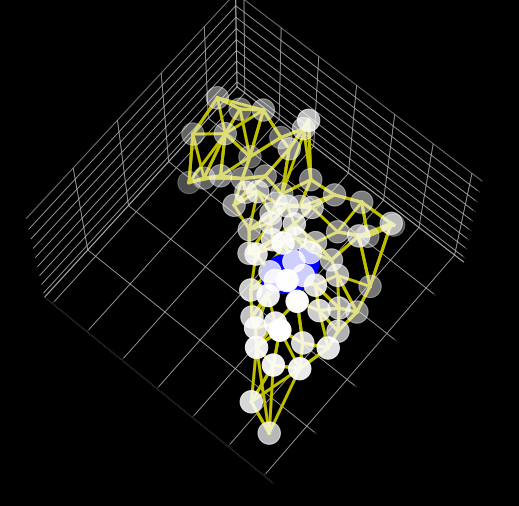

In [188]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(sub_embedding['row']*scale, sub_embedding['col']*scale,sub_embedding['z']*z_scale,'.',color='w', s=500)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

for item in connected_pairs:
    ax.plot([sub_embedding.loc[item[0]]['row'].astype('float')*scale, sub_embedding.loc[item[1]]['row'].astype('float')*scale],
            [sub_embedding.loc[item[0]]['col'].astype('float')*scale, sub_embedding.loc[item[1]]['col'].astype('float')*scale],
            [sub_embedding.loc[item[0]]['z'].astype('float')*z_scale, sub_embedding.loc[item[1]]['z'].astype('float')*z_scale],
            color='y',linewidth=3)

ax.view_init(-110, 50)
plt.tight_layout()
plt.savefig(r'.\figures\uc_018_01_patch_networks_dapi.png')

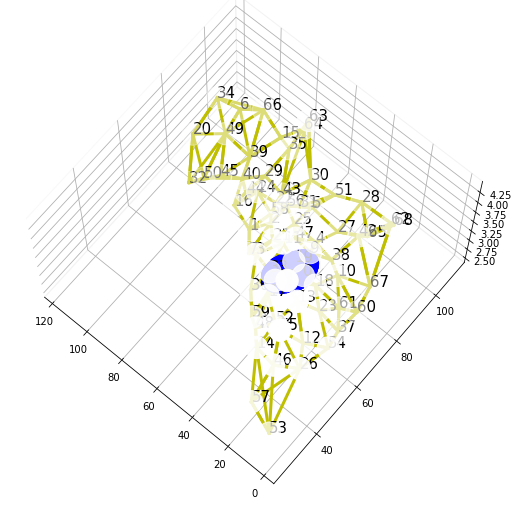

In [174]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
# fig.set_facecolor('black')
# ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(sub_embedding['row']*scale, sub_embedding['col']*scale,sub_embedding['z']*z_scale,'.',color='w', s=500)

# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

for item in connected_pairs:
    ax.plot([sub_embedding.loc[item[0]]['row'].astype('float')*scale, sub_embedding.loc[item[1]]['row'].astype('float')*scale],
            [sub_embedding.loc[item[0]]['col'].astype('float')*scale, sub_embedding.loc[item[1]]['col'].astype('float')*scale],
            [sub_embedding.loc[item[0]]['z'].astype('float')*z_scale, sub_embedding.loc[item[1]]['z'].astype('float')*z_scale],
            color='y',linewidth=3)

for idx in sub_embedding.index:
    s = idx.split('_')[3]
    ax.text(sub_embedding.loc[idx]['row']*scale, sub_embedding.loc[idx]['col']*scale, sub_embedding.loc[idx]['z']*z_scale,s=s,fontsize=15)

ax.view_init(-110, 50)
plt.tight_layout()
# plt.savefig(r'.\figures\uc_018_01_patch_networks_dapi.png')

In [179]:
patches = ['uc_018_01_25','uc_018_01_4','uc_018_01_47','uc_018_01_5']

In [84]:
region = sub_embedding.loc[patches]

NameError: name 'sub_embedding' is not defined

In [183]:
region_pairs = []
for p in connected_pairs:
    if p[0] in patches and p[1] in patches:
        region_pairs.append(p)

In [184]:
edge_row = []
edge_col = []
edge_z = []
for item in region_pairs:
    edge_row.append(region.loc[item[0]]['row'].astype('float'))
    edge_row.append(region.loc[item[1]]['row'].astype('float'))
    edge_row.append(None)
    
    edge_col.append(region.loc[item[0]]['col'].astype('float'))
    edge_col.append(region.loc[item[1]]['col'].astype('float'))
    edge_col.append(None)
    
    edge_z.append(region.loc[item[0]]['z'].astype('float'))
    edge_z.append(region.loc[item[1]]['z'].astype('float'))
    edge_z.append(None)

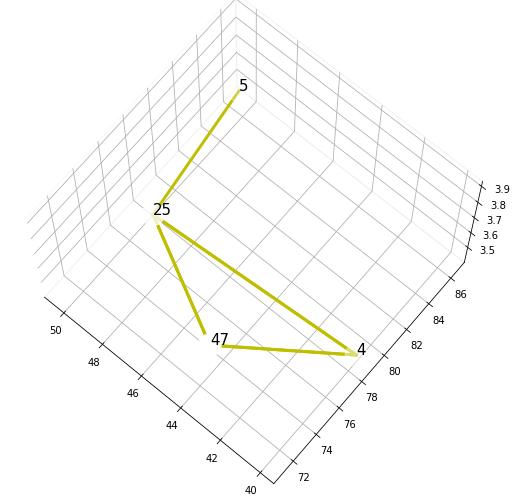

In [196]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
# fig.set_facecolor('black')
# ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

# ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(region['row']*scale, region['col']*scale,region['z']*z_scale,'.',color='w', s=500)

# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

for item in region_pairs:
    ax.plot([region.loc[item[0]]['row'].astype('float')*scale, region.loc[item[1]]['row'].astype('float')*scale],
            [region.loc[item[0]]['col'].astype('float')*scale, region.loc[item[1]]['col'].astype('float')*scale],
            [region.loc[item[0]]['z'].astype('float')*z_scale, region.loc[item[1]]['z'].astype('float')*z_scale],
            color='y',linewidth=3)

for idx in region.index:
    s = idx.split('_')[3]
    ax.text(region.loc[idx]['row']*scale, region.loc[idx]['col']*scale, region.loc[idx]['z']*z_scale,s=s,fontsize=15)

ax.view_init(-110, 50)
plt.tight_layout()
# plt.savefig(r'.\figures\uc_018_01_patch_networks_dapi.png')

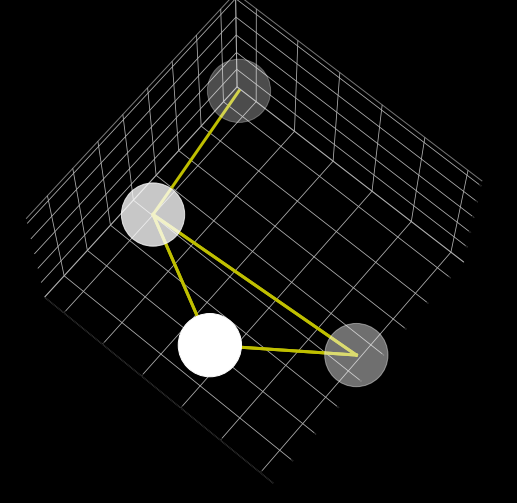

In [194]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

# ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(region['row']*scale, region['col']*scale,region['z']*z_scale,'.',color='w', s=4000)

# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

for item in region_pairs:
    ax.plot([region.loc[item[0]]['row'].astype('float')*scale, region.loc[item[1]]['row'].astype('float')*scale],
            [region.loc[item[0]]['col'].astype('float')*scale, region.loc[item[1]]['col'].astype('float')*scale],
            [region.loc[item[0]]['z'].astype('float')*z_scale, region.loc[item[1]]['z'].astype('float')*z_scale],
            color='y',linewidth=3)

# for idx in region.index:
#     s = idx.split('_')[3]
#     ax.text(region.loc[idx]['row']*scale, region.loc[idx]['col']*scale, region.loc[idx]['z']*z_scale,s=s,fontsize=15)

ax.view_init(-110, 50)
plt.tight_layout()
plt.savefig(r'.\figures\uc_018_01_local_networks.png')

## uc_018_02

In [89]:
sub_embedding = embedding[embedding.index.str.contains('uc_018_02')]

In [90]:
connected_pairs = nha.find_connected_pairs(sub_embedding,5,'row','col','z')

In [91]:
mask = tifffile.imread(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_segmentation\cellpose\combined_rna\uc_rgb_combined\masks\018_mask.tif')
mask = (mask==2).astype('int')

dapi_mip = tifffile.imread(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_segmentation\cellpose\combined_rna\uc_rgb_combined\imgs\018_image.tif')
dapi_mip = dapi_mip[2,:,:]

masked_dapi = mask * dapi_mip
thre = threshold_otsu(masked_dapi)
dapi_mask = masked_dapi > thre

dapi_coor = np.where(dapi_mask)
dapi_row = dapi_coor[0].astype('float') * scale
dapi_col = dapi_coor[1].astype('float') * scale

dapi_z = 12 * z_scale

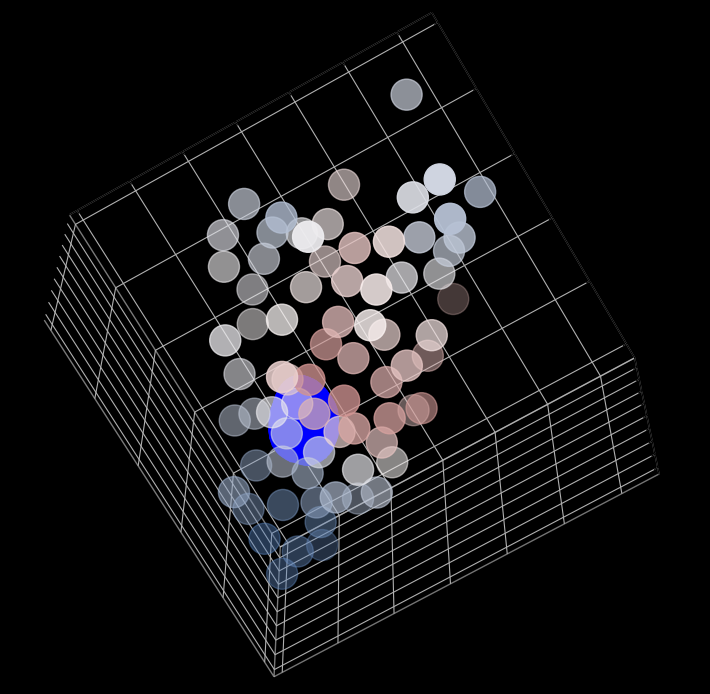

In [93]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(sub_embedding['row']*scale, sub_embedding['col']*scale,sub_embedding['z']*z_scale,'.',
           c=sub_embedding['24'], s=500, cmap='vlag', vmin=-0.5, vmax=0.5)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

# for item in connected_pairs:
#     ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
#             color='y',linewidth=3)

ax.view_init(-70, -60)
plt.tight_layout()
plt.savefig(r'.\figures\uc_018_02_embedding_24.png')

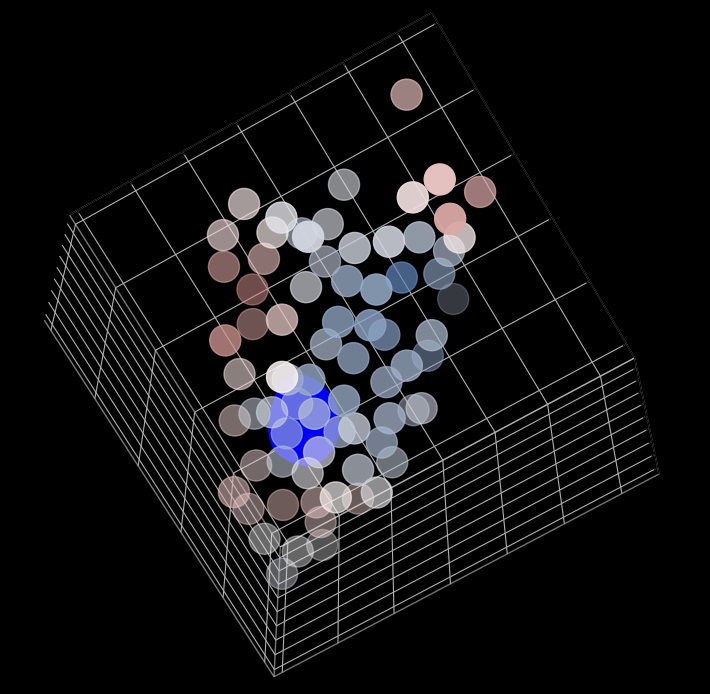

In [94]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(sub_embedding['row']*scale, sub_embedding['col']*scale,sub_embedding['z']*z_scale,'.',
           c=sub_embedding['46'], s=500, cmap='vlag', vmin=-0.5, vmax=0.5)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

# for item in connected_pairs:
#     ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
#             color='y',linewidth=3)

ax.view_init(-70, -60)
plt.tight_layout()
plt.savefig(r'.\figures\uc_018_01_embedding_46.png')

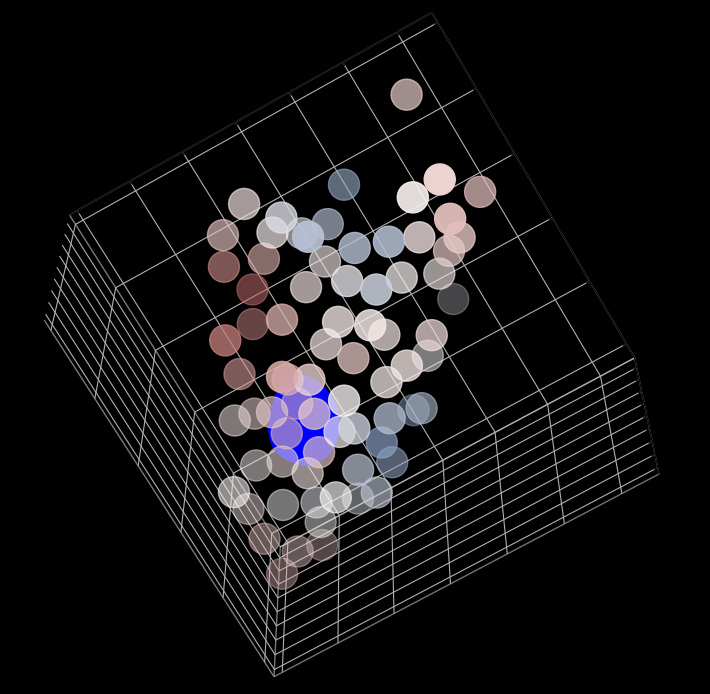

In [96]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(sub_embedding['row']*scale, sub_embedding['col']*scale,sub_embedding['z']*z_scale,'.',
           c=sub_embedding['59'], s=500, cmap='vlag', vmin=-0.5, vmax=0.5)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

# for item in connected_pairs:
#     ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
#             color='y',linewidth=3)

ax.view_init(-70, -60)
plt.tight_layout()
plt.savefig(r'.\figures\uc_018_02_embedding_59.png')

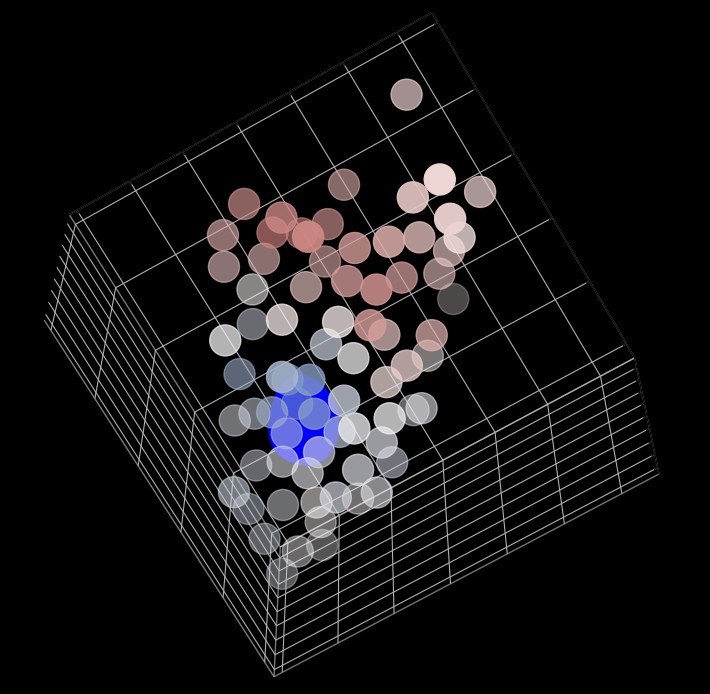

In [97]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(sub_embedding['row']*scale, sub_embedding['col']*scale,sub_embedding['z']*z_scale,'.',
           c=sub_embedding['75'], s=500, cmap='vlag', vmin=-0.5, vmax=0.5)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

# for item in connected_pairs:
#     ax.plot([bm_007_13.loc[item[0]]['row'].astype('float')*scale, bm_007_13.loc[item[1]]['row'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['col'].astype('float')*scale, bm_007_13.loc[item[1]]['col'].astype('float')*scale],
#             [bm_007_13.loc[item[0]]['z'].astype('float')*z_scale, bm_007_13.loc[item[1]]['z'].astype('float')*z_scale],
#             color='y',linewidth=3)

ax.view_init(-70, -60)
plt.tight_layout()
plt.savefig(r'.\figures\uc_018_02_embedding_75.png')

In [98]:
edge_row = []
edge_col = []
edge_z = []
for item in connected_pairs:
    edge_row.append(sub_embedding.loc[item[0]]['row'].astype('float'))
    edge_row.append(sub_embedding.loc[item[1]]['row'].astype('float'))
    edge_row.append(None)
    
    edge_col.append(sub_embedding.loc[item[0]]['col'].astype('float'))
    edge_col.append(sub_embedding.loc[item[1]]['col'].astype('float'))
    edge_col.append(None)
    
    edge_z.append(sub_embedding.loc[item[0]]['z'].astype('float'))
    edge_z.append(sub_embedding.loc[item[1]]['z'].astype('float'))
    edge_z.append(None)

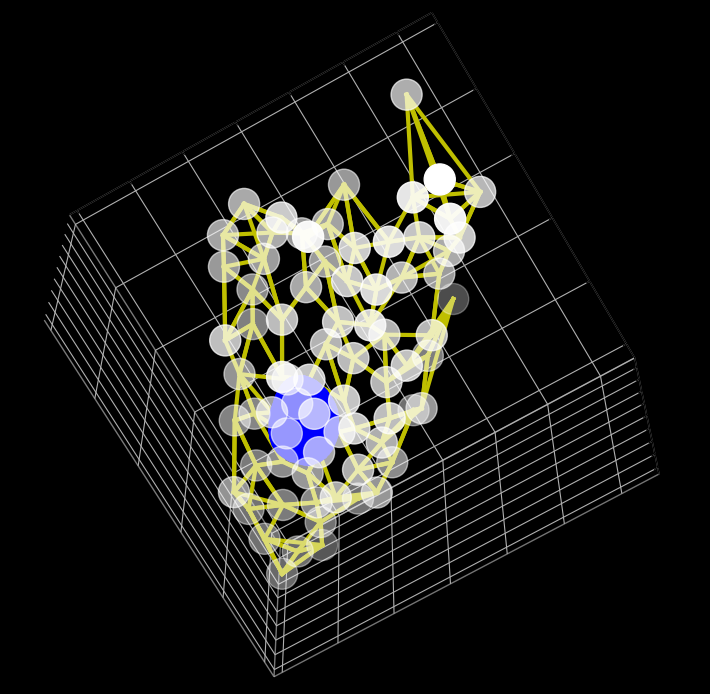

In [100]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(sub_embedding['row']*scale, sub_embedding['col']*scale,sub_embedding['z']*z_scale,'.',color='w', s=500)
# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

for item in connected_pairs:
    ax.plot([sub_embedding.loc[item[0]]['row'].astype('float')*scale, sub_embedding.loc[item[1]]['row'].astype('float')*scale],
            [sub_embedding.loc[item[0]]['col'].astype('float')*scale, sub_embedding.loc[item[1]]['col'].astype('float')*scale],
            [sub_embedding.loc[item[0]]['z'].astype('float')*z_scale, sub_embedding.loc[item[1]]['z'].astype('float')*z_scale],
            color='y',linewidth=3)

ax.view_init(-70, -60)
plt.tight_layout()
plt.savefig(r'.\figures\uc_018_02_patch_networks_dapi.png')

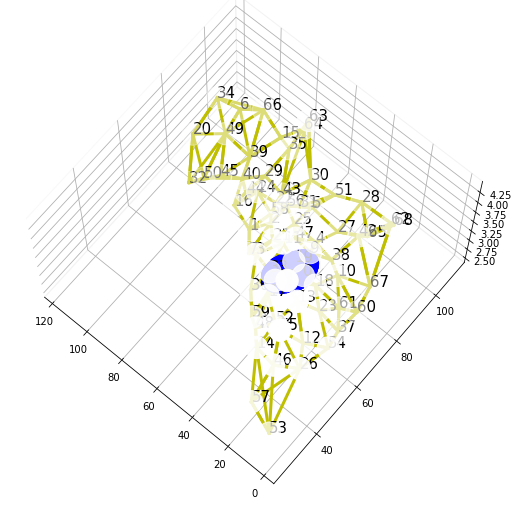

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
# fig.set_facecolor('black')
# ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(sub_embedding['row']*scale, sub_embedding['col']*scale,sub_embedding['z']*z_scale,'.',color='w', s=500)

# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

for item in connected_pairs:
    ax.plot([sub_embedding.loc[item[0]]['row'].astype('float')*scale, sub_embedding.loc[item[1]]['row'].astype('float')*scale],
            [sub_embedding.loc[item[0]]['col'].astype('float')*scale, sub_embedding.loc[item[1]]['col'].astype('float')*scale],
            [sub_embedding.loc[item[0]]['z'].astype('float')*z_scale, sub_embedding.loc[item[1]]['z'].astype('float')*z_scale],
            color='y',linewidth=3)

for idx in sub_embedding.index:
    s = idx.split('_')[3]
    ax.text(sub_embedding.loc[idx]['row']*scale, sub_embedding.loc[idx]['col']*scale, sub_embedding.loc[idx]['z']*z_scale,s=s,fontsize=15)

ax.view_init(-110, 50)
plt.tight_layout()
# plt.savefig(r'.\figures\uc_018_01_patch_networks_dapi.png')

In [ ]:
patches = ['uc_018_01_25','uc_018_01_4','uc_018_01_47','uc_018_01_5']

In [ ]:
region = sub_embedding.loc[patches]

NameError: name 'sub_embedding' is not defined

In [ ]:
region_pairs = []
for p in connected_pairs:
    if p[0] in patches and p[1] in patches:
        region_pairs.append(p)

In [ ]:
edge_row = []
edge_col = []
edge_z = []
for item in region_pairs:
    edge_row.append(region.loc[item[0]]['row'].astype('float'))
    edge_row.append(region.loc[item[1]]['row'].astype('float'))
    edge_row.append(None)
    
    edge_col.append(region.loc[item[0]]['col'].astype('float'))
    edge_col.append(region.loc[item[1]]['col'].astype('float'))
    edge_col.append(None)
    
    edge_z.append(region.loc[item[0]]['z'].astype('float'))
    edge_z.append(region.loc[item[1]]['z'].astype('float'))
    edge_z.append(None)

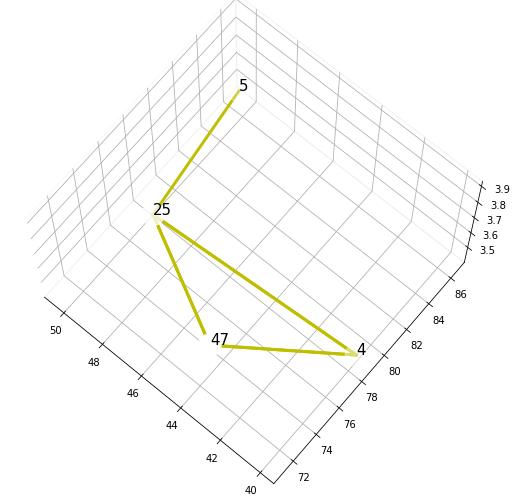

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
# fig.set_facecolor('black')
# ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

# ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(region['row']*scale, region['col']*scale,region['z']*z_scale,'.',color='w', s=500)

# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

for item in region_pairs:
    ax.plot([region.loc[item[0]]['row'].astype('float')*scale, region.loc[item[1]]['row'].astype('float')*scale],
            [region.loc[item[0]]['col'].astype('float')*scale, region.loc[item[1]]['col'].astype('float')*scale],
            [region.loc[item[0]]['z'].astype('float')*z_scale, region.loc[item[1]]['z'].astype('float')*z_scale],
            color='y',linewidth=3)

for idx in region.index:
    s = idx.split('_')[3]
    ax.text(region.loc[idx]['row']*scale, region.loc[idx]['col']*scale, region.loc[idx]['z']*z_scale,s=s,fontsize=15)

ax.view_init(-110, 50)
plt.tight_layout()
# plt.savefig(r'.\figures\uc_018_01_patch_networks_dapi.png')

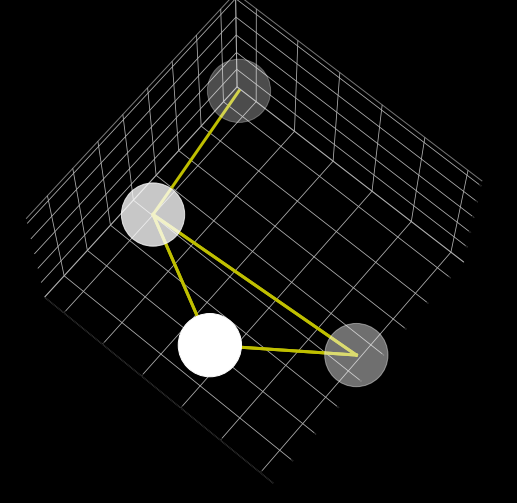

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()

# ax.scatter(dapi_row,dapi_col,dapi_z,color='b',s=1)
ax.scatter(region['row']*scale, region['col']*scale,region['z']*z_scale,'.',color='w', s=4000)

# ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

for item in region_pairs:
    ax.plot([region.loc[item[0]]['row'].astype('float')*scale, region.loc[item[1]]['row'].astype('float')*scale],
            [region.loc[item[0]]['col'].astype('float')*scale, region.loc[item[1]]['col'].astype('float')*scale],
            [region.loc[item[0]]['z'].astype('float')*z_scale, region.loc[item[1]]['z'].astype('float')*z_scale],
            color='y',linewidth=3)

# for idx in region.index:
#     s = idx.split('_')[3]
#     ax.text(region.loc[idx]['row']*scale, region.loc[idx]['col']*scale, region.loc[idx]['z']*z_scale,s=s,fontsize=15)

ax.view_init(-110, 50)
plt.tight_layout()
plt.savefig(r'.\figures\uc_018_01_local_networks.png')

# other

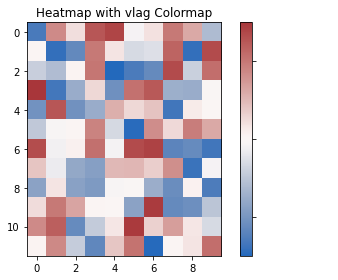

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Sample data
data = np.random.uniform(-3, 3, (12, 10))  # Generating random data between -3 and 3

# Create a figure and axes
fig, ax = plt.subplots()

# Create a heatmap with the 'vlag' colormap
heatmap = ax.imshow(data, cmap='vlag', vmin=-3, vmax=3)

# Create a colorbar
cbar = plt.colorbar(heatmap)

# Customize colorbar label text properties
cbar.set_label('Colorbar Label', color='white', weight='bold', fontsize=25)

# Customize colorbar tick labels text properties
cbar.ax.tick_params(labelcolor='white', labelsize=30)

# Add title
ax.set_title('Heatmap with vlag Colormap')

# Show the plot
plt.tight_layout()
plt.savefig(r'.\figures\cmap.png')
plt.show()

In [170]:
from matplotlib import rcParams

In [171]:
rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
          'axes.gri

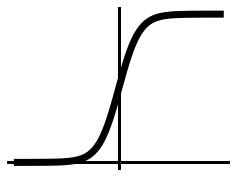

In [203]:
# Sigmoid plot
# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Generate x values
x = np.linspace(-10, 10, 100)

# Calculate y values using the sigmoid function
y = sigmoid(x)

# Create the plot
with rc_context({'figure.figsize':(4,3),'axes.facecolor':'none','axes.spines.bottom':False,
                 'axes.spines.left':False,'axes.spines.right':False,'axes.spines.top':False,
                 'axes.grid':True}):
    fig, ax = plt.subplots()
    ax.plot(x, y, linewidth=7, color='black', label='Sigmoid Function')
    ax.axhline(0, color='black', linewidth=3)  # Add x-axis line
    ax.axvline(0, color='black', linewidth=3)  # Add y-axis line
    # ax.set_xlabel('X Axis')
    # ax.set_ylabel('Y Axis')
    # ax.set_title('Sigmoid Function', fontsize=14)
    ax.set_xticks([])  # Turn off x-axis ticks and labels
    ax.set_yticks([])  # Turn off y-axis ticks and labels
    # ax.legend()
    ax.grid('off')
    ax.patch.set_facecolor('none')
    plt.savefig(r'.\figures\sigmoid_plot.png', dpi=300)
    plt.show()

# UC 018-01 patch correlation

In [158]:
cell_df = pd.read_csv(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_analysis\spagnn\cell_df\uc_018_01.csv',index_col=0)

In [161]:
patch_count = util.counting(cell_df,'patch','gene')

In [163]:
patch_count.drop(columns=['Count_id'],inplace=True)

In [165]:
uc_018_01_corr = patch_count.corr(method='pearson')

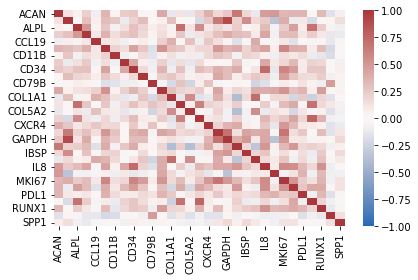

In [168]:
sns.heatmap(uc_018_01_corr, cmap='vlag', vmin=-1, vmax=1)
plt.tight_layout()
plt.savefig(r'.\figures\uc_018_01_corr.png')

# Plotting expanation graph

In [4]:
cell_explanation = pd.read_pickle(r'.\results\explainer\bm_001_01.pkl')

In [5]:
proxi_df = pd.read_csv(r'.\results\proxi_df.csv',index_col=0)
edges = pd.read_pickle(r'.\results\patch_connected_pairs.pkl')

In [6]:
proxi_by_cell = proxi_df.groupby('cellID')

In [7]:
cell_temp = proxi_by_cell.get_group('bm_001_01')

In [8]:
edge_colors = cell_explanation['edge_mask']
edge_colors = (edge_colors - edge_colors.min()) / (edge_colors.max() - edge_colors.min())

node_colors = cell_explanation['node_mask']
node_colors = np.abs(node_colors)
node_colors = np.sum(node_colors,axis=1)
node_colors = (node_colors - node_colors.min()) / (node_colors.max() - node_colors.min())

In [9]:
cell_explanation['edge_mask'].shape

(92,)

In [10]:
filtered_edges = []
for item in edges[0]:
    if item[0] == item[1]:
        continue
    else:
        filtered_edges.append(item)

In [12]:
# len(edges_temp)

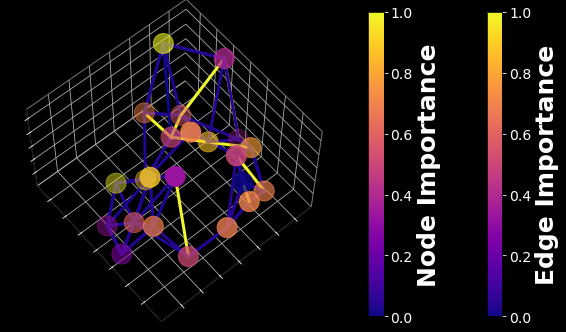

In [13]:
with plt.rc_context({'text.color': 'white', 'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white'}):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(projection='3d')
    fig.set_facecolor('black')
    ax.set_facecolor('black')
    ax.w_xaxis.pane.fill = False
    ax.w_yaxis.pane.fill = False
    ax.w_zaxis.pane.fill = False
    ax.invert_zaxis()

    node_cmap = plt.cm.plasma

    node_c = node_cmap(node_colors)
    ax.scatter(cell_temp['row']*scale, cell_temp['col']*scale, cell_temp['z']*z_scale, '.', c=node_c, s=400)
    # ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

    edge_cmap = plt.cm.plasma
    for i in range(len(filtered_edges)):
        item = filtered_edges[i]
        edge_c = edge_cmap(edge_colors[i])
        ax.plot([cell_temp.loc[item[0]]['row'].astype('float')*scale, cell_temp.loc[item[1]]['row'].astype('float')*scale],
                [cell_temp.loc[item[0]]['col'].astype('float')*scale, cell_temp.loc[item[1]]['col'].astype('float')*scale],
                [cell_temp.loc[item[0]]['z'].astype('float')*z_scale, cell_temp.loc[item[1]]['z'].astype('float')*z_scale],
                c=edge_c,linewidth=3)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    edge_mappable = plt.cm.ScalarMappable(cmap=edge_cmap)
    edge_cb = plt.colorbar(edge_mappable, ax=ax, label='Edge Importance', pad=0.1, shrink=0.8)
    edge_cb.ax.yaxis.set_tick_params(labelsize=14, color='white')
    edge_cb.set_label('Edge Importance', color='white', weight='bold', fontsize=25)

    node_mappable = plt.cm.ScalarMappable(cmap=node_cmap)
    node_cb = plt.colorbar(node_mappable, ax=ax, label='Node Importance', pad=0.1, shrink=0.8)
    node_cb.ax.yaxis.set_tick_params(labelsize=14, color='white')
    node_cb.set_label('Node Importance', color='white', weight='bold', fontsize=25)

    ax.view_init(60, 50)
    # plt.tight_layout()
    # plt.savefig(r'.\figures\uc_018_01_patch_networks_dapi.png')

In [14]:
out_dir = r'.\figures\graph_importance'
fn_l = os.listdir(r'.\results\explainer')
fn_l.sort()
for j,fn in tqdm(enumerate(fn_l)):
    cell = fn.split('.')[0]
    cell_temp = proxi_by_cell.get_group(cell)
    cell_explanation = pd.read_pickle(os.path.join(r'.\results\explainer',fn))
    
    edge_colors = cell_explanation['edge_mask']
    edge_colors = (edge_colors - edge_colors.min()) / (edge_colors.max() - edge_colors.min())
    
    node_colors = cell_explanation['node_mask']
    node_colors = np.abs(node_colors)
    node_colors = np.sum(node_colors,axis=1)
    node_colors = (node_colors - node_colors.min()) / (node_colors.max() - node_colors.min())
    
    filtered_edges = []
    for item in edges[j]:
        if item[0] == item[1]:
            continue
        else:
            filtered_edges.append(item)
    
    with plt.rc_context({'text.color': 'white', 'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white'}):
        fig = plt.figure(figsize=(10,7))
        ax = fig.add_subplot(projection='3d')
        fig.set_facecolor('black')
        ax.set_facecolor('black')
        ax.w_xaxis.pane.fill = False
        ax.w_yaxis.pane.fill = False
        ax.w_zaxis.pane.fill = False
        ax.invert_zaxis()

        node_cmap = plt.cm.plasma

        node_c = node_cmap(node_colors)
        ax.scatter(cell_temp['row']*scale, cell_temp['col']*scale, cell_temp['z']*z_scale, '.', c=node_c, s=200)
        # ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

        edge_cmap = plt.cm.plasma
        for i in range(len(filtered_edges)):
            item = filtered_edges[i]
            edge_c = edge_cmap(edge_colors[i])
            ax.plot([cell_temp.loc[item[0]]['row'].astype('float')*scale, cell_temp.loc[item[1]]['row'].astype('float')*scale],
                    [cell_temp.loc[item[0]]['col'].astype('float')*scale, cell_temp.loc[item[1]]['col'].astype('float')*scale],
                    [cell_temp.loc[item[0]]['z'].astype('float')*z_scale, cell_temp.loc[item[1]]['z'].astype('float')*z_scale],
                    c=edge_c,linewidth=3)
        
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        
        edge_mappable = plt.cm.ScalarMappable(cmap=edge_cmap)
        edge_cb = plt.colorbar(edge_mappable, ax=ax, label='Edge Importance', pad=0.1, shrink=0.8)
        edge_cb.ax.yaxis.set_tick_params(labelsize=14, color='white')
        edge_cb.set_label('Edge Importance', color='white', weight='bold', fontsize=25)

        node_mappable = plt.cm.ScalarMappable(cmap=node_cmap)
        node_cb = plt.colorbar(node_mappable, ax=ax, label='Node Importance', pad=0.1, shrink=0.8)
        node_cb.ax.yaxis.set_tick_params(labelsize=14, color='white')
        node_cb.set_label('Node Importance', color='white', weight='bold', fontsize=25)

        ax.view_init(60, 50)
        # plt.tight_layout()
        plt.savefig(os.path.join(out_dir,cell+'.png'))
        plt.close()

553it [07:16,  1.27it/s]


## bm 007-13 explanation

In [15]:
cell_explanation = pd.read_pickle(r'.\results\explainer\bm_007_13.pkl')

In [16]:
proxi_df = pd.read_csv(r'.\results\proxi_df.csv',index_col=0)
edges = pd.read_pickle(r'.\results\patch_connected_pairs.pkl')

In [17]:
proxi_by_cell = proxi_df.groupby('cellID')

In [18]:
cell_temp = proxi_by_cell.get_group('bm_007_13')

In [19]:
edge_colors = cell_explanation['edge_mask']
edge_colors = (edge_colors - edge_colors.min()) / (edge_colors.max() - edge_colors.min())

node_colors = cell_explanation['node_mask']
node_colors = np.abs(node_colors)
node_colors = np.sum(node_colors,axis=1)
node_colors = (node_colors - node_colors.min()) / (node_colors.max() - node_colors.min())

In [20]:
idx = list(proxi_df['cellID'].unique()).index('bm_007_13')
filtered_edges = []
for item in edges[idx]:
    if item[0] == item[1]:
        continue
    else:
        filtered_edges.append(item)

C:\Users\zfang38\AppData\Local\Temp\ipykernel_119760\1201550355.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


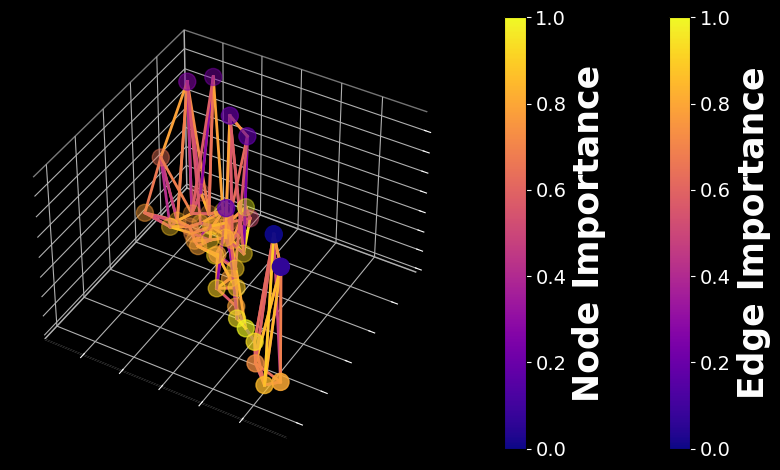

In [21]:
with plt.rc_context({'text.color': 'white', 'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white'}):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(projection='3d')
    fig.set_facecolor('black')
    ax.set_facecolor('black')
    ax.w_xaxis.pane.fill = False
    ax.w_yaxis.pane.fill = False
    ax.w_zaxis.pane.fill = False
    ax.invert_zaxis()

    node_cmap = plt.cm.plasma

    node_c = node_cmap(node_colors)
    ax.scatter(cell_temp['row']*scale, cell_temp['col']*scale, cell_temp['z']*z_scale, '.', c=node_c, s=150)
    # ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

    edge_cmap = plt.cm.plasma
    for i in range(len(filtered_edges)):
        item = filtered_edges[i]
        edge_c = edge_cmap(edge_colors[i])
        ax.plot([cell_temp.loc[item[0]]['row'].astype('float')*scale, cell_temp.loc[item[1]]['row'].astype('float')*scale],
                [cell_temp.loc[item[0]]['col'].astype('float')*scale, cell_temp.loc[item[1]]['col'].astype('float')*scale],
                [cell_temp.loc[item[0]]['z'].astype('float')*z_scale, cell_temp.loc[item[1]]['z'].astype('float')*z_scale],
                c=edge_c,linewidth=2)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    edge_mappable = plt.cm.ScalarMappable(cmap=edge_cmap)
    edge_cb = plt.colorbar(edge_mappable, ax=ax, label='Edge Importance', pad=0.1, shrink=0.8)
    edge_cb.ax.yaxis.set_tick_params(labelsize=14, color='white')
    edge_cb.set_label('Edge Importance', color='white', weight='bold', fontsize=25)

    node_mappable = plt.cm.ScalarMappable(cmap=node_cmap)
    node_cb = plt.colorbar(node_mappable, ax=ax, label='Node Importance', pad=0.1, shrink=0.8)
    node_cb.ax.yaxis.set_tick_params(labelsize=14, color='white')
    node_cb.set_label('Node Importance', color='white', weight='bold', fontsize=25)

    ax.view_init(-140, 60)
    plt.tight_layout()
    # plt.savefig(r'.\figures\bm_007_13_patch_networks_importance.png')

## uc_018_02

In [68]:
cell_explanation = pd.read_pickle(r'.\results\explainer\uc_018_02.pkl')

In [69]:
cell_temp = proxi_by_cell.get_group('uc_018_02')

In [70]:
cell_temp.shape

(75, 487)

In [71]:
edge_colors = cell_explanation['edge_mask']
edge_colors = (edge_colors - edge_colors.min()) / (edge_colors.max() - edge_colors.min())

node_colors = cell_explanation['node_mask']
node_colors = np.abs(node_colors)
node_colors = np.sum(node_colors,axis=1)
node_colors = (node_colors - node_colors.min()) / (node_colors.max() - node_colors.min())

In [72]:
node_colors.shape

(75,)

In [73]:
idx = list(proxi_df['cellID'].unique()).index('uc_018_02')
filtered_edges = []
for item in edges[idx]:
    if item[0] == item[1]:
        continue
    else:
        filtered_edges.append(item)

C:\Users\zfang38\AppData\Local\Temp\ipykernel_13236\2813867324.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


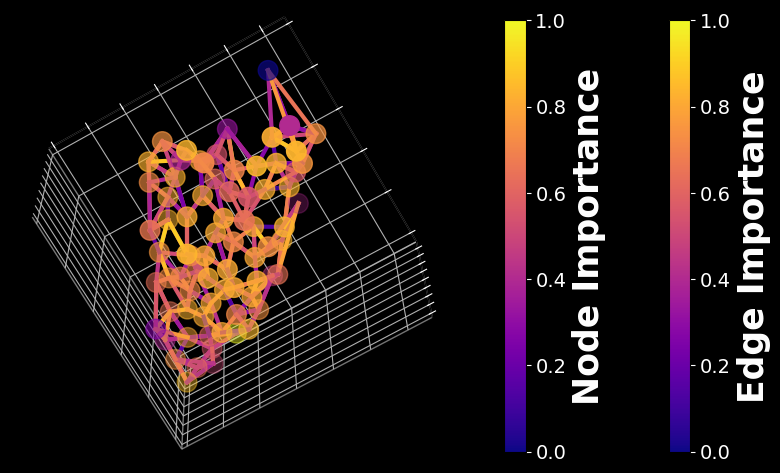

In [83]:
with plt.rc_context({'text.color': 'white', 'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white'}):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(projection='3d')
    fig.set_facecolor('black')
    ax.set_facecolor('black')
    ax.w_xaxis.pane.fill = False
    ax.w_yaxis.pane.fill = False
    ax.w_zaxis.pane.fill = False
    ax.invert_zaxis()

    node_cmap = plt.cm.plasma

    node_c = node_cmap(node_colors)
    ax.scatter(cell_temp['row']*scale, cell_temp['col']*scale, cell_temp['z']*z_scale, '.', c=node_c, s=200)
    # ax.plot(edge_row*scale, edge_col*scale, edge_z*scale, color='r')

    edge_cmap = plt.cm.plasma
    for i in range(len(filtered_edges)):
        item = filtered_edges[i]
        edge_c = edge_cmap(edge_colors[i])
        ax.plot([cell_temp.loc[item[0]]['row'].astype('float')*scale, cell_temp.loc[item[1]]['row'].astype('float')*scale],
                [cell_temp.loc[item[0]]['col'].astype('float')*scale, cell_temp.loc[item[1]]['col'].astype('float')*scale],
                [cell_temp.loc[item[0]]['z'].astype('float')*z_scale, cell_temp.loc[item[1]]['z'].astype('float')*z_scale],
                c=edge_c,linewidth=3)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    edge_mappable = plt.cm.ScalarMappable(cmap=edge_cmap)
    edge_cb = plt.colorbar(edge_mappable, ax=ax, label='Edge Importance', pad=0.1, shrink=0.8)
    edge_cb.ax.yaxis.set_tick_params(labelsize=14, color='white')
    edge_cb.set_label('Edge Importance', color='white', weight='bold', fontsize=25)

    node_mappable = plt.cm.ScalarMappable(cmap=node_cmap)
    node_cb = plt.colorbar(node_mappable, ax=ax, label='Node Importance', pad=0.1, shrink=0.8)
    node_cb.ax.yaxis.set_tick_params(labelsize=14, color='white')
    node_cb.set_label('Node Importance', color='white', weight='bold', fontsize=25)

    ax.view_init(-70, -60)
    plt.tight_layout()
    plt.savefig(r'.\figures\uc_018_02_patch_networks_importance.png')

# Average patch sizes

In [5]:
in_dir = r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_analysis\spagnn\cell_df'
df_l = os.listdir(in_dir)
df_l.sort()
idx = np.random.randint(0,len(df_l)-1,10)
temp = []
for i in idx:
    temp.append(pd.read_csv(os.path.join(in_dir,df_l[i])))

In [7]:
for item in temp:
    print(item['patch'].value_counts().mean())

468.3272727272727
240.91666666666666
384.8979591836735
279.5
384.8979591836735
603.3333333333334
145.94444444444446
355.0204081632653
204.11363636363637
175.60416666666666
